codecell 1: imports\
codecell 2 : defining deterministic environment\
codecell 3 : Running deterministic environment for 10 timesteps\
codecell 4: defining stochastic environment\
codecell 5 : running stochastic environment for 10 timestamps\
codecell 6: defining Q learning \
codecell 7 : test_policy(ignore)\
codecell 8:  Running Q Learnig for deterministic environment(it contains the plots replated to it)\
codecell 9: defining run_greedy_policy\
codecell 10: definining greedy policy and rendering \
codecell 11: runnin codecell 9 & 10 for deterministic environment\
codecell 12 : defining gamma_tuning\
codecell 13: running gamma tuning for deterministic env(contaains plots)\
codecell 14 : defining alpha_tuning\
codecell 15: running alpha tuning for deterministic env(contaains plots)\
codecell 16: defining SARS\
codecell 17: running sarsa for deterministic environment \
codecell 18: Running Q Learnig for stochastic  environment(it contains the plots related to it)\
codecell 19: runnin codecell 9 & 10 for stochastic environment\
codecell 20: running gamma tuning for Stochastic env(contaains plots)\
codecell 21: running alpha  tuning for Stochastic env(contaains plots)\
codecell 22: implementing SARSA for stochastic\

In [1]:
#CodeCell 1

import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import optuna

c:\Users\jaiad\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#CodeCell 2
class DeterministicDroneDeliveryEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.grid_size = 6
        self.no_fly_zones = [(2,2), (2,3), (3,2), (3,3)]
        self.action_space = gym.spaces.Discrete(5)  # Up, Down, Left, Right, Pickup/Dropoff
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Box(0, 5, (2,), dtype=int),  # Drone position
            gym.spaces.Discrete(4),  # Carrying capacity (0-3 packages)
            gym.spaces.MultiBinary(3)  # Delivery status for each customer
        ))
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.drone_pos = np.array([0, 0], dtype=int)
        self.carrying = 3
        self.num_customers = 3
        self.delivery_locations = [(1, 2), (4, 4), (5, 0)]  # Fixed delivery locations
        self.deliveries_completed = [False] * self.num_customers
        self.steps = 0
        return self._get_obs(), {}

    def step(self, action):
        self.steps += 1
        reward = -1  # Default step penalty
        terminated = False

        if action < 4:  # Movement
            new_pos = self.drone_pos.copy()
            if action == 0: new_pos[1] = min(5, new_pos[1]-1)  # Up
            elif action == 1: new_pos[1] = max(0, new_pos[1]+1)  # Down
            elif action == 2: new_pos[0] = max(0, new_pos[0]-1)  # Left
            elif action == 3: new_pos[0] = min(5, new_pos[0]+1)  # Right

            if self._is_valid(new_pos):
                self.drone_pos = new_pos
            else:
                reward = -100  # No-fly zone penalty

        elif action == 4:  # Pickup/Dropoff
            if np.array_equal(self.drone_pos, [0, 0]):  # At warehouse
                pass
            else:
                for i, loc in enumerate(self.delivery_locations):
                    if np.array_equal(self.drone_pos, loc) and self.carrying > 0 and not self.deliveries_completed[i]:
                        self.deliveries_completed[i] = True
                        self.carrying -= 1
                        reward = 100
                        break

        # Check if all tasks are completed
        if all(self.deliveries_completed):
            terminated = True
            reward += 500  # Bonus for completing all tasks

        return self._get_obs(), reward, terminated, False, {}

    def _is_valid(self, pos):
        return (tuple(pos) not in self.no_fly_zones 
                and 0 <= pos[0] < self.grid_size 
                and 0 <= pos[1] < self.grid_size)

    def _get_obs(self):
        return (self.drone_pos.copy(), 
                self.carrying, 
                np.array(self.deliveries_completed))

    def render(self):
        grid = np.full((6,6), '⬜')
        for x,y in self.no_fly_zones:
            grid[y,x] = '🟥'
        
        for i, (x, y) in enumerate(self.delivery_locations):
            if not self.deliveries_completed[i]:
                grid[y,x] = f'📦{i+1}'
        
        grid[self.drone_pos[1], self.drone_pos[0]] = '🚁' #+ str(self.carrying)
        
        print('\n'.join([' '.join(row) for row in grid]))
        print(f"Carrying: {self.carrying} packages")
        print(f"Deliveries completed: {sum(self.deliveries_completed)}/{self.num_customers}")



In [3]:
#CodeCell 3
# Example usage
env = DeterministicDroneDeliveryEnv()
obs, _ = env.reset()

print("Initial State:")
env.render()

for t in range(10):
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, _ = env.step(action)
    
    print(f"\nTimestep {t+1}")
    print(f"State: {obs}")
    print(f"Action: {['Up', 'Down', 'Left', 'Right', 'Pickup/Dropoff'][action]}")
    print(f"Reward: {reward}")
    env.render()
    
    obs = next_obs
    if terminated:
        print("Episode finished early.")
        break

print("Random agent simulation completed.")

Initial State:
🚁 ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 1
State: (array([0, 0]), 3, array([False, False, False]))
Action: Pickup/Dropoff
Reward: -1
🚁 ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 2
State: (array([0, 0]), 3, array([False, False, False]))
Action: Right
Reward: -1
⬜ 🚁 ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 3
State: (array([1, 0]), 3, array([False, False, False]))
Action: Right
Reward: -1
⬜ ⬜ 🚁 ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 4
State: (array([2, 0]), 3, array([False, False, False]))
Action: Left
Reward: -1
⬜ 🚁 ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 

In [4]:
#CodeCell 4
class StochasticDroneDeliveryEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.grid_size = 6
        self.no_fly_zones = [(2,2), (2,3), (3,2), (3,3)]
        self.action_space = gym.spaces.Discrete(5)  # Up, Down, Left, Right, Pickup/Dropoff
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Box(0, 5, (2,), dtype=int),  # Drone position
            gym.spaces.Discrete(4),  # Carrying capacity (0-3 packages)
            gym.spaces.MultiBinary(3)  # Delivery status for each customer
        ))
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.drone_pos = np.array([0, 0], dtype=int)
        self.carrying = 3
        self.num_customers = 3
        self.delivery_locations = [(1, 2), (4, 4), (5, 0)]  # Fixed delivery locations
        self.deliveries_completed = [False] * self.num_customers
        self.steps = 0
        return self._get_obs(), {}

    def step(self, action):
        self.steps += 1
        reward = -1  # Default step penalty
        terminated = False

        if action < 4:  # Movement
            new_pos = self.drone_pos.copy()
            if action == 0:  # Up
                if np.random.rand() < 0.9:
                    new_pos[1] = min(5, new_pos[1]-1)
                else:
                    new_pos = self._deviate(new_pos, action)
            elif action == 1:  # Down
                if np.random.rand() < 0.9:
                    new_pos[1] = max(0, new_pos[1]+1)
                else:
                    new_pos = self._deviate(new_pos, action)
            elif action == 2:  # Left
                if np.random.rand() < 0.9:
                    new_pos[0] = max(0, new_pos[0]-1)
                else:
                    new_pos = self._deviate(new_pos, action)
            elif action == 3:  # Right
                if np.random.rand() < 0.9:
                    new_pos[0] = min(5, new_pos[0]+1)
                else:
                    new_pos = self._deviate(new_pos, action)

            if self._is_valid(new_pos):
                self.drone_pos = new_pos
            else:
                reward = -100  # No-fly zone penalty

        elif action == 4:  # Pickup/Dropoff
            if np.array_equal(self.drone_pos, [0, 0]):  # At warehouse
                pass
            else:
                for i, loc in enumerate(self.delivery_locations):
                    if np.array_equal(self.drone_pos, loc) and self.carrying > 0 and not self.deliveries_completed[i]:
                        self.deliveries_completed[i] = True
                        self.carrying -= 1
                        reward = 100
                        break

        # Check if all tasks are completed
        if all(self.deliveries_completed):
            terminated = True
            reward += 500  # Bonus for completing all tasks

        return self._get_obs(), reward, terminated, False, {}

    def _deviate(self, pos, action):
        if action == 0 or action == 1:  # Up or Down
            if np.random.rand() < 0.5:
                pos[0] = max(0, pos[0]-1)  # Deviate Left
            else:
                pos[0] = min(5, pos[0]+1)  # Deviate Right
        elif action == 2 or action == 3:  # Left or Right
            if np.random.rand() < 0.5:
                pos[1] = min(5, pos[1]+1)  # Deviate Down
            else:
                pos[1] = max(0, pos[1]-1)  # Deviate Up
        return pos

    def _is_valid(self, pos):
        return (tuple(pos) not in self.no_fly_zones 
                and 0 <= pos[0] < self.grid_size 
                and 0 <= pos[1] < self.grid_size)

    def _get_obs(self):
        return (self.drone_pos.copy(), 
                self.carrying, 
                np.array(self.deliveries_completed))

    def render(self):
        grid = np.full((6,6), '⬜')
        for x,y in self.no_fly_zones:
            grid[y,x] = '🟥'
        
        for i, (x, y) in enumerate(self.delivery_locations):
            if not self.deliveries_completed[i]:
                grid[y,x] = f'📦{i+1}'
        
        grid[self.drone_pos[1], self.drone_pos[0]] = '🚁' #+ str(self.carrying)
        
        print('\n'.join([' '.join(row) for row in grid]))
        print(f"Carrying: {self.carrying} packages")
        print(f"Deliveries completed: {sum(self.deliveries_completed)}/{self.num_customers}")

In [5]:
#CodeCell 5
# Example usage
env = StochasticDroneDeliveryEnv()
obs, _ = env.reset()

print("Initial State:")
env.render()

for t in range(10):
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, _ = env.step(action)
    
    print(f"\nTimestep {t+1}")
    print(f"State: {obs}")
    print(f"Action: {['Up', 'Down', 'Left', 'Right', 'Pickup/Dropoff'][action]}")
    print(f"Reward: {reward}")
    env.render()
    
    obs = next_obs
    if terminated:
        print("Episode finished early.")
        break

print("Random agent simulation completed.")

Initial State:
🚁 ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 1
State: (array([0, 0]), 3, array([False, False, False]))
Action: Down
Reward: -1
⬜ ⬜ ⬜ ⬜ ⬜ 📦
🚁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 2
State: (array([0, 1]), 3, array([False, False, False]))
Action: Down
Reward: -1
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🚁 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 3
State: (array([0, 2]), 3, array([False, False, False]))
Action: Right
Reward: -1
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🚁 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 4
State: (array([1, 2]), 3, array([False, False, False]))
Action: Right
Reward: -100
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🚁 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Timestep 5
State:

⬜: Empty cell
🟥: No-fly zone
🚁: Drone (with carrying capacity)
📦: Package delivery location






In [6]:
#CodeCell 6
#Q Learning implementation
# Initialize state space dimensions
np.set_printoptions(threshold=np.inf,  # Show all elements
                   linewidth=150,       # Wider display
                   precision=2,         # 2 decimal places
                   suppress=True)       # Don't use scientific notation
grid_size = 6
n_deliveries = 3
n_states = grid_size * grid_size * (2**n_deliveries)  # 288 states 
n_actions = 5

def state_to_index(state):
    
    pos, _, deliveries = state  # Ignore carrying value
    pos_idx = pos[0] * grid_size + pos[1]  # Convert 2D position to 1D (0-35)
    deliveries_idx = sum(int(d) << i for i, d in enumerate(deliveries))  # Binary encoding (0-7)
    return int(pos_idx + (grid_size * grid_size * deliveries_idx))

def q_learning(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, 
              min_epsilon=0.01, num_episodes=10, showplts=False, return_rewards=False):
    
    # Initialize Q-table with reduced state space
    q_table = np.zeros((n_states, n_actions), dtype=np.float32)
    print("Initial Q-table:")
    print(q_table)
    total_rewards = np.zeros(num_episodes, dtype=np.float32)
    epsilon_values = np.zeros(num_episodes, dtype=np.float32)
    
    try:
        for episode in range(num_episodes):
            state, _ = env.reset()
            state_idx = state_to_index(state)
            total_reward = 0
            done = False
            
            while not done:
                # Epsilon-greedy action selection
                if np.random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = int(np.argmax(q_table[state_idx]))
                
                # Take action
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state_idx = state_to_index(next_state)
                
                # Q-learning update (vectorized)
                current_q = q_table[state_idx, action]
                next_max_q = np.max(q_table[next_state_idx])
                new_q = current_q + alpha * (reward + gamma * next_max_q - current_q)
                q_table[state_idx, action] = new_q
                #print("q_table updated")
                #print(reward)
                state_idx = next_state_idx
                total_reward += reward
            
            # Update tracking variables
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            total_rewards[episode] = total_reward
            epsilon_values[episode] = epsilon
            
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(total_rewards[max(0, episode-9):episode+1])
                print(f"Episode {episode+1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}")
        
        if showplts:
            plot_training_results(total_rewards, epsilon_values, num_episodes)
        
        print("Full Q-table:")
        print(q_table)
        if return_rewards:
            return q_table, total_rewards
        return q_table
    
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return None

def plot_training_results(total_rewards, epsilon_values, num_episodes):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot rewards
    ax1.plot(np.arange(num_episodes), total_rewards, 'b-')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('TotalRewards per Episode')
    
    # Plot smoothed rewards
    window_size = min(10, num_episodes)
    smoothed_rewards = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(np.arange(len(smoothed_rewards)), smoothed_rewards, 'r-', alpha=0.5, label='Smoothed')
    ax1.legend()
    
    # Plot epsilon decay
    ax2.plot(np.arange(num_episodes), epsilon_values, 'g-')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon Value')
    ax2.set_title('Epsilon Decay')
    
    plt.tight_layout()
    plt.show()

In [7]:
#codeCell 7
def test_policy(env, q_table, num_episodes=100):
    total_rewards = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        terminated = False

        while not terminated:
            action = np.argmax(q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_rewards += reward
            state = next_state

    avg_reward = total_rewards / num_episodes
    print(f"Average reward: {avg_reward}")
    return avg_reward

Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 

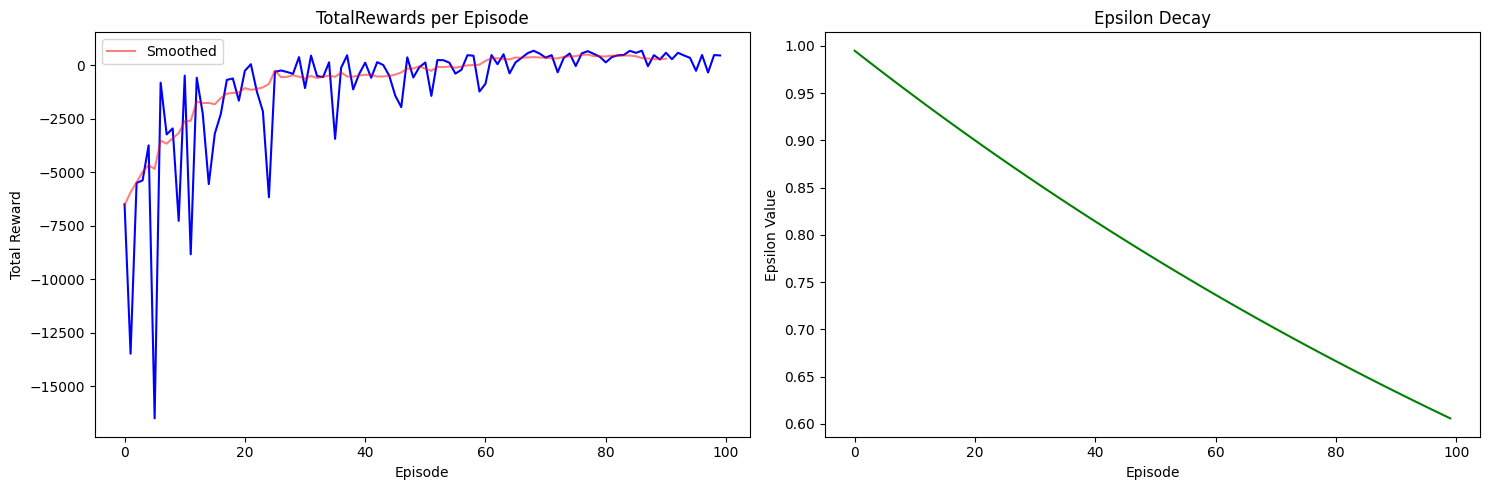

Full Q-table:
[[  -3.91   85.24   91.16  117.71   87.54]
 [  67.91   92.34   54.93  111.07   63.63]
 [  47.68   25.85   66.91  151.75   84.09]
 [  61.72    0.57   12.67   39.06   16.05]
 [  11.65   -0.94    0.12    1.34    0.1 ]
 [  -0.07  -74.75   -0.82   -0.32   -0.88]
 [   1.41  136.71   84.76   82.62   94.2 ]
 [  92.72  163.88   82.48   73.7   107.01]
 [  99.86   71.38  105.4    27.32  204.6 ]
 [ 109.09    9.21   24.76  -37.3    47.71]
 [  35.86   -0.12    0.44    0.47    9.47]
 [   5.39  -65.28   -0.76   -0.56   -0.85]
 [ -54.95   30.87  104.71    7.25   54.48]
 [  56.81  -49.77   94.65   11.65   45.91]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -46.76   -0.9     6.38    6.27    0.14]
 [  -0.42  -46.9    -0.77    1.18   -0.58]
 [ -56.82    1.73   43.3    -0.3     3.63]
 [   4.41  -64.5    27.09   -0.74    3.37]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -50.19   -0.15    1.19   24.16    1.7

In [8]:
#codeCell 8
env=DeterministicDroneDeliveryEnv()
q_table=q_learning(env,num_episodes=100,showplts=True)

# Save the Q-table/Policy table as a pickle file of the trained model
with open('deterministic_env_q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)


In [9]:
#CodeCell 9

def run_greedy_policy(env, q_table, num_episodes=10):
   
    total_rewards = np.zeros(num_episodes, dtype=np.float32)

    for episode in range(num_episodes):
        state, _ = env.reset()
        state_idx = state_to_index(state)  # Convert state to index
        total_reward = 0
        terminated = False

        while not terminated:
            # Select action greedily from Q-table
            action = int(np.argmax(q_table[state_idx]))
            
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state_idx = state_to_index(next_state)
            
            total_reward += reward
            state_idx = next_state_idx

        total_rewards[episode] = total_reward

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(num_episodes), total_rewards, 'bo-', label='Episode Reward')
    
    # Add moving average
    window_size = min(5, num_episodes)
    moving_avg = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(np.arange(len(moving_avg)), moving_avg, 'r-', label='Moving Average')
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Greedy Policy Evaluation Results')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return total_rewards.tolist()  # Convert to list for compatibility

In [10]:

# CodeCell 10
def run_greedy_policy_and_render(env, q_table, max_steps=100):
    
    state, _ = env.reset()
    state_idx = state_to_index(state)
    total_reward = 0
    step = 0
    terminated = False
    
    # Store trajectory for analysis
    trajectory = []
    action_names = ['Up', 'Down', 'Left', 'Right', 'Pickup/Dropoff']
    
    print("Initial State:")
    env.render()
    
    while not terminated and step < max_steps:
        # Get greedy action from Q-table
        action = int(np.argmax(q_table[state_idx]))
        trajectory.append((state, action))
        
        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state_idx = state_to_index(next_state)
        
        # Update tracking variables
        total_reward += reward
        state = next_state
        state_idx = next_state_idx
        step += 1
        
        # Render environment state
        print(f"\nStep {step}")
        print(f"Action: {action_names[action]}")
        print(f"Reward: {reward}")
        print(f"Current Total Reward: {total_reward}")
        env.render()
    
    # Final statistics
    print("\nEpisode Summary:")
    print(f"Total Steps: {step}")
    print(f"Final Reward: {total_reward}")
    print(f"Terminated: {terminated}")
    
    if step >= max_steps:
        print("Warning: Episode reached maximum steps!")
    
    # Visualize trajectory
    '''
    if hasattr(env, 'grid_size'):
        plt.figure(figsize=(6, 6))
        plt.grid(True)
        plt.title('Agent Trajectory')
        
        # Plot trajectory
        traj_states = np.array([t[0][0] for t in trajectory])
        plt.plot(traj_states[:, 1], traj_states[:, 0], 'b-o', alpha=0.6)
        plt.plot(traj_states[0, 1], traj_states[0, 0], 'go', label='Start')
        plt.plot(traj_states[-1, 1], traj_states[-1, 0], 'ro', label='End')
        
        plt.xlim(-0.5, env.grid_size - 0.5)
        plt.ylim(-0.5, env.grid_size - 0.5)
        plt.legend()
        plt.show()
    '''
    
    return {
        'total_reward': total_reward,
        'steps': step,
        'trajectory': trajectory,
        'terminated': terminated
    }

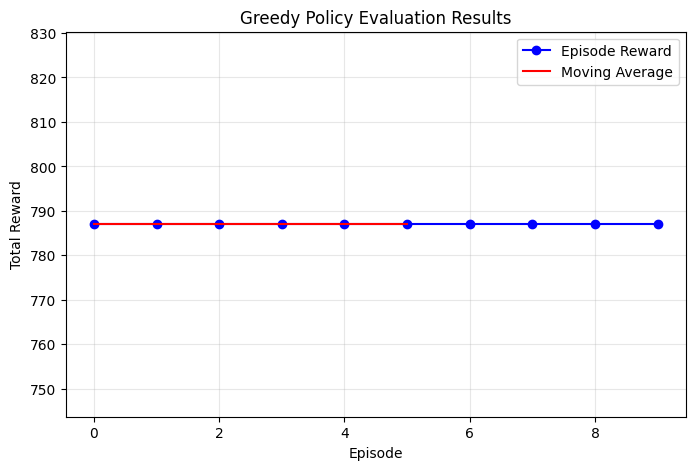

Initial State:
🚁 ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Step 1
Action: Right
Reward: -1
Current Total Reward: -1
⬜ 🚁 ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Step 2
Action: Down
Reward: -1
Current Total Reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ 🚁 ⬜ ⬜ ⬜ ⬜
⬜ 📦 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Step 3
Action: Down
Reward: -1
Current Total Reward: -3
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🚁 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 3 packages
Deliveries completed: 0/3

Step 4
Action: Pickup/Dropoff
Reward: 100
Current Total Reward: 97
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🚁 🟥 🟥 ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 2 packages
Deliveries completed: 1/3

Step 5
Action: Down
Reward: -1
Current Total Reward: 96
⬜ ⬜ ⬜ ⬜ ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ 🟥 🟥 ⬜ ⬜
⬜ 🚁 🟥 🟥 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 📦 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Carrying: 2 packages


{'total_reward': 787,
 'steps': 16,
 'trajectory': [((array([0, 0]), 3, array([False, False, False])), 3),
  ((array([1, 0]), 3, array([False, False, False])), 1),
  ((array([1, 1]), 3, array([False, False, False])), 1),
  ((array([1, 2]), 3, array([False, False, False])), 4),
  ((array([1, 2]), 2, array([ True, False, False])), 1),
  ((array([1, 3]), 2, array([ True, False, False])), 1),
  ((array([1, 4]), 2, array([ True, False, False])), 3),
  ((array([2, 4]), 2, array([ True, False, False])), 3),
  ((array([3, 4]), 2, array([ True, False, False])), 3),
  ((array([4, 4]), 2, array([ True, False, False])), 4),
  ((array([4, 4]), 1, array([ True,  True, False])), 3),
  ((array([5, 4]), 1, array([ True,  True, False])), 0),
  ((array([5, 3]), 1, array([ True,  True, False])), 0),
  ((array([5, 2]), 1, array([ True,  True, False])), 0),
  ((array([5, 1]), 1, array([ True,  True, False])), 0),
  ((array([5, 0]), 1, array([ True,  True, False])), 4)],
 'terminated': True}

In [11]:
#codeCell 11
env=DeterministicDroneDeliveryEnv()
# Run the greedy policy and plot the results
run_greedy_policy(env, q_table, num_episodes=10)
# Run the greedy policy and render the results
run_greedy_policy_and_render(env, q_table)

In [12]:
#codeCell 12
def gamma_tuning(env, num_episodes=100):
    
    # Select practical gamma values
    gamma_values = [0.9, 0.95, 0.99]  # Common values for discounted rewards
    results = {}
    
    for gamma in gamma_values:
        print(f"\nTraining with gamma = {gamma}")
        
        # Train Q-learning with current gamma
        q_table, training_rewards = q_learning(
            env=env,
            gamma=gamma,
            alpha=0.1,
            epsilon=1.0,
            epsilon_decay=0.995,
            min_epsilon=0.01,
            num_episodes=num_episodes,
            showplts=True,
            return_rewards=True
        )
        #print(f"Final Q-table : {q_table}")
        # Run greedy policy
        
        
        results[gamma] = {
            'q_table': q_table,
            'mean_reward': np.mean(training_rewards[-10:]),  # Last 10 episodes
            'std_reward': np.std(training_rewards[-10:])
        }
    run_greedy_policy(env, q_table, num_episodes=10)
    # Visualization
    plt.figure(figsize=(10, 6))
    
    # Plot mean rewards with error bars
    gammas = list(results.keys())
    means = [results[g]['mean_reward'] for g in gammas]
    stds = [results[g]['std_reward'] for g in gammas]
    
    plt.errorbar(gammas, means, yerr=stds, fmt='bo-', capsize=5, 
                label='Mean Reward ± Std')
    
    plt.xlabel('Gamma Value')
    plt.ylabel('Average Reward')
    plt.title('Q-Learning Performance vs Gamma')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Print results
    print("\nResults Summary:")
    for gamma in gamma_values:
        print(f"\nGamma = {gamma}")
        print(f"Mean Reward: {results[gamma]['mean_reward']:.2f}")
        print(f"Std Reward: {results[gamma]['std_reward']:.2f}")
    
    # Return best gamma
    best_gamma = max(results.keys(), key=lambda g: results[g]['mean_reward'])
    print(f"\nBest gamma value: {best_gamma}")
    
    return results




Training with gamma = 0.9
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [

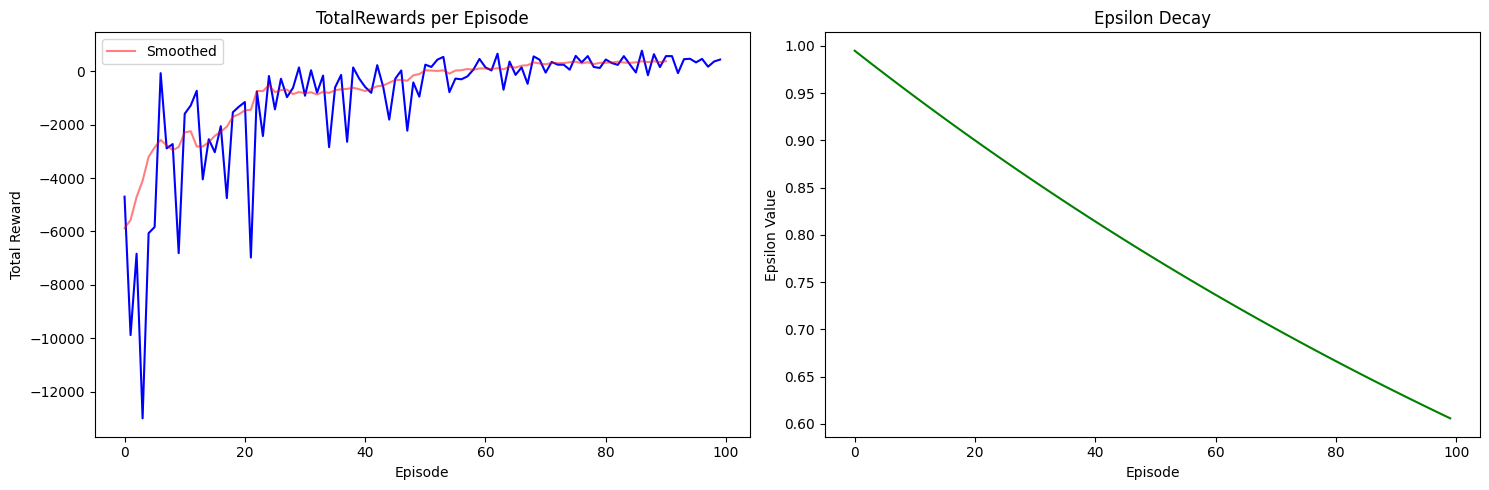

Full Q-table:
[[-47.05  72.08  48.35  63.93  50.92]
 [ 45.35  77.2   63.79  84.83  60.46]
 [ 54.44  38.03  59.51  95.89  55.45]
 [ 69.05   5.29  18.42  27.53  20.63]
 [ 28.25  -0.72   0.82   5.75   2.33]
 [  0.47 -34.47  -0.85  -0.9   -0.82]
 [-55.59  84.48  40.74  23.96  54.53]
 [ 64.29 102.59  63.57  52.19  74.94]
 [ 68.8   55.87  71.47  -6.4  123.94]
 [ 82.13  15.14  30.15 -42.38  36.99]
 [ 38.    -0.9    2.95   0.17  13.4 ]
 [ -0.45 -61.36  -1.06  -0.67  -0.49]
 [-73.27  40.67  47.14   4.49  14.86]
 [ 16.94 -66.82  76.32  10.86  38.7 ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-46.41  -0.42   7.32  -0.27   0.17]
 [ -0.07 -34.39  -0.51  -0.35  -0.35]
 [-77.39   3.18  18.05   0.6    3.62]
 [  1.36 -79.89  30.41  -0.71   3.13]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-10.     0.    -0.3    0.71  -0.1 ]
 [ -0.13 -19.    -0.37  -0.19  -0.35]
 [-27.1   -0.69  -0.39   6.2   -0.13]
 [ -0.15  -0.63   0.51  -0.3   -0.47

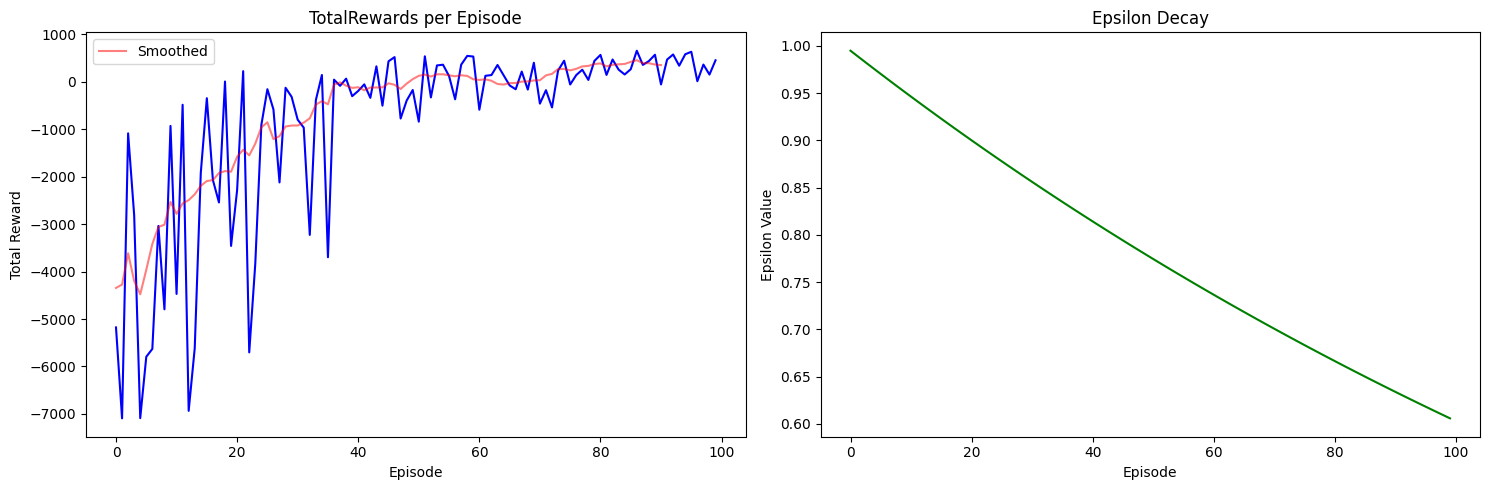

Full Q-table:
[[-29.3   96.57  71.21  70.12  64.48]
 [ 68.64 119.56  75.85  76.57  73.91]
 [ 76.84  66.33 104.96 141.57 107.93]
 [ 74.38  32.1   45.36  87.65  52.17]
 [ 35.35   7.41  25.85  57.19  18.96]
 [ 26.68 -55.93  -0.68   2.65   2.91]
 [-40.    97.56  33.43  16.38  53.13]
 [ 66.39 121.63  74.6   63.68  75.62]
 [ 91.29  93.58  91.79  22.65 174.7 ]
 [128.97  52.87  59.1  -17.74  76.49]
 [ 81.96  21.04  27.75  21.15  51.74]
 [ 42.13 -46.77   2.01   2.16   6.11]
 [-75.58  41.85  25.8    3.48  15.75]
 [ 13.56 -53.19  91.52  26.69  43.69]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-42.55   1.72  45.27   0.81   6.32]
 [  9.61 -76.45  10.19  -0.4    0.51]
 [-75.81  19.51   8.94   0.31   0.71]
 [  4.66 -49.79  50.    -0.44  11.87]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-18.24  -0.39  10.53   2.47   0.26]
 [  0.97 -40.95  -0.09   2.92  -0.32]
 [-40.43  -0.35  -0.19   4.42   0.02]
 [ -0.07  -0.1    0.39  -0.27  -0.5 

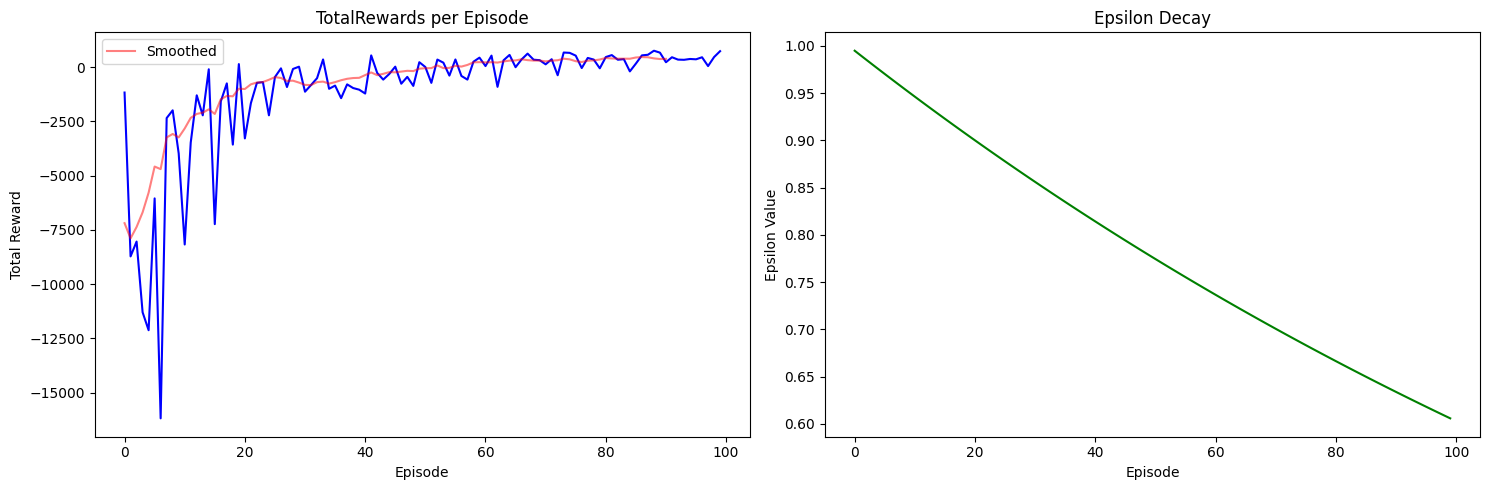

Full Q-table:
[[-22.03  97.35  75.67  78.25  77.15]
 [ 67.58  89.72  73.97 103.95  80.29]
 [ 54.49  58.65  83.33 106.39  82.49]
 [ 82.1    6.38  19.74  36.06  25.99]
 [ 25.39   0.88   3.81   5.18   2.09]
 [  9.07 -41.05  -0.68  -0.5   -0.8 ]
 [-27.43  99.13  46.87  28.85  69.63]
 [ 84.2  110.74  78.83  75.27  90.55]
 [ 94.84  71.16  90.3   -2.88 119.02]
 [ 94.85  10.04  31.41 -33.51  40.96]
 [ 35.79  -0.61   4.37  -0.36   0.25]
 [  0.69 -40.98  -0.81  -0.49  -0.56]
 [-77.49  59.84  42.98   2.22  12.74]
 [ 24.27 -36.79  94.02  13.54  45.56]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-40.97  -0.29  -0.28  -0.04  -0.47]
 [ -0.5  -65.21  -0.31  -0.42  -0.39]
 [-87.16   3.87  18.11   2.3    0.1 ]
 [  1.18 -75.24  32.3    0.67   4.56]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-18.93  -0.28   0.     4.77  -0.2 ]
 [  0.05 -46.87  -0.51  -0.1   -0.37]
 [-44.23  -0.18  -0.18  22.39   0.64]
 [  1.66  -0.19   1.85   7.09   0.32

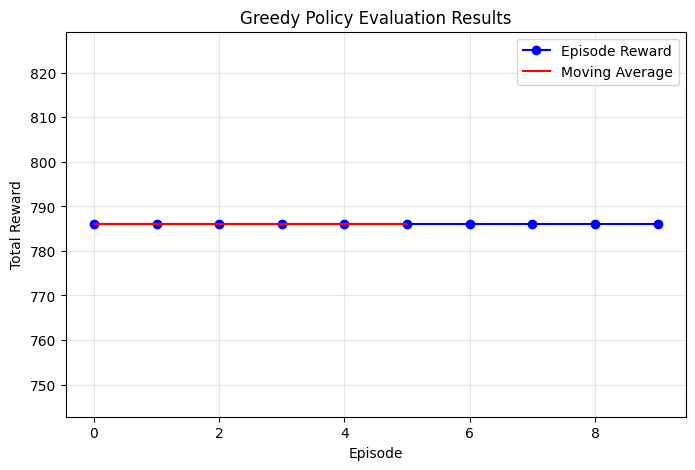

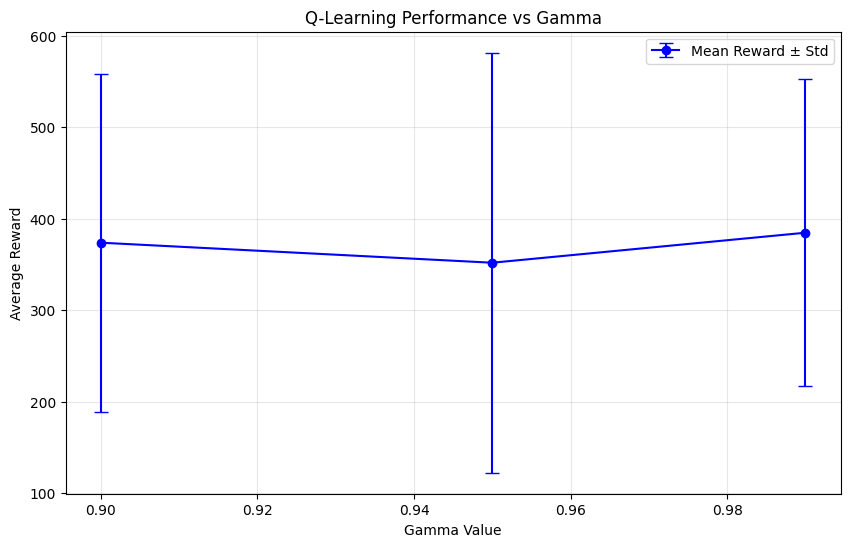


Results Summary:

Gamma = 0.9
Mean Reward: 373.90
Std Reward: 184.94

Gamma = 0.95
Mean Reward: 352.00
Std Reward: 229.59

Gamma = 0.99
Mean Reward: 384.80
Std Reward: 167.84

Best gamma value: 0.99


In [13]:
#codeCell 13
env= DeterministicDroneDeliveryEnv()
results = gamma_tuning(env)


In [14]:
#codeCell 14
def epsilon_decay_tuning(env, num_episodes=100):
    """
    Evaluate Q-learning performance with different epsilon decay values
    
    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes for each epsilon decay evaluation
    Returns:
        dict: Results for each epsilon decay value
    """
    # Select practical epsilon decay values
    epsilon_decay_values = [0.99, 0.995, 0.999]  # Common values for epsilon decay
    results = {}
    
    for epsilon_decay in epsilon_decay_values:
        print(f"\nTraining with epsilon decay = {epsilon_decay}")
        
        # Train Q-learning with current epsilon decay
        q_table, training_rewards = q_learning(
            env=env,
            gamma=0.99,
            alpha=0.1,
            epsilon=1.0,
            epsilon_decay=epsilon_decay,
            min_epsilon=0.01,
            num_episodes=num_episodes,
            showplts=True,
            return_rewards=True
        )
        
        # Run greedy policy
        run_greedy_policy(env, q_table, num_episodes=10)
        
        results[epsilon_decay] = {
            'q_table': q_table,
            'mean_reward': np.mean(training_rewards[-10:]),  # Last 10 episodes
            'std_reward': np.std(training_rewards[-10:])
        }
    
    # Visualization
    plt.figure(figsize=(10, 6))
    
    # Plot mean rewards with error bars
    decays = list(results.keys())
    means = [results[d]['mean_reward'] for d in decays]
    stds = [results[d]['std_reward'] for d in decays]
    
    plt.errorbar(decays, means, yerr=stds, fmt='bo-', capsize=5, 
                label='Mean Reward ± Std')
    
    plt.xlabel('Epsilon Decay Value')
    plt.ylabel('Average Reward')
    plt.title('Q-Learning Performance vs Epsilon Decay')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Print results
    print("\nResults Summary:")
    for epsilon_decay in epsilon_decay_values:
        print(f"\nEpsilon Decay = {epsilon_decay}")
        print(f"Mean Reward: {results[epsilon_decay]['mean_reward']:.2f}")
        print(f"Std Reward: {results[epsilon_decay]['std_reward']:.2f}")
    
    # Return best epsilon decay
    best_decay = max(results.keys(), key=lambda d: results[d]['mean_reward'])
    print(f"\nBest epsilon decay value: {best_decay}")
    
    return results



Training with epsilon decay = 0.99
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 

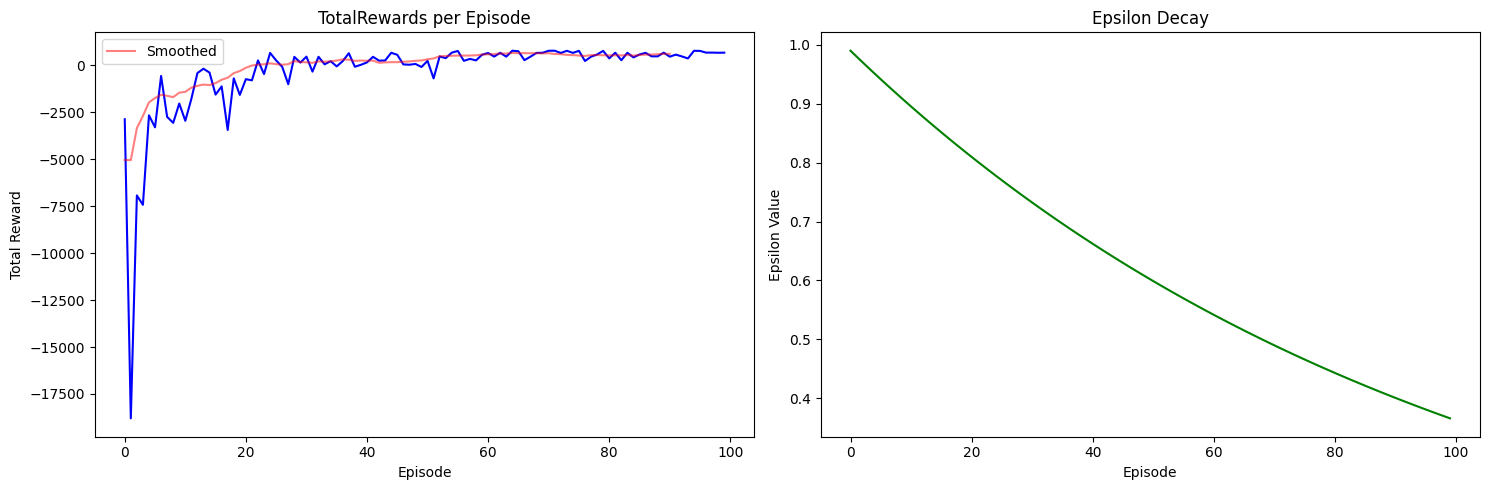

Full Q-table:
[[-30.51 115.48  47.42  26.43  39.76]
 [ 28.06 133.75  68.19  43.76  62.97]
 [ 56.14  23.77  56.55 160.95  73.7 ]
 [  5.27  -0.19   3.43  63.98   7.86]
 [  5.72  -0.81  -0.25  -0.52  -0.55]
 [ -0.51 -27.16  -0.69  -0.64  -0.59]
 [-83.93  59.94  19.17  -1.32   7.37]
 [ 13.01 124.51  37.16   3.36  52.23]
 [ 71.77  68.34  70.28  16.76 199.02]
 [115.95   5.37   8.81 -43.95  26.23]
 [ 24.95  -0.7   -0.42  -0.44  -0.5 ]
 [  0.8  -65.27  -0.56  -0.44  -0.5 ]
 [-77.35  -0.65   6.06  -0.53  -0.95]
 [ -0.97 -56.08  30.5   -0.43  -0.09]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-56.93  -0.21  -0.47   1.54  -0.55]
 [ -0.22 -19.    -0.32  -0.19  -0.29]
 [-34.3   -0.55  -0.68   1.74  -0.56]
 [ -0.28 -27.1   -0.38   0.27  -0.36]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-26.77  -0.27  -0.22  15.83   1.85]
 [ -0.18 -10.    -0.1   -0.1   -0.1 ]
 [-54.82   0.05  -0.47   8.52   1.26]
 [  2.67  -0.12  -0.09  -0.11   0.21

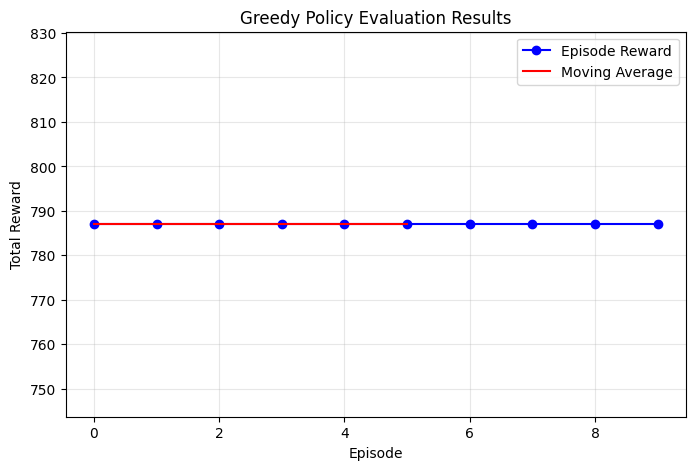


Training with epsilon decay = 0.995
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0.

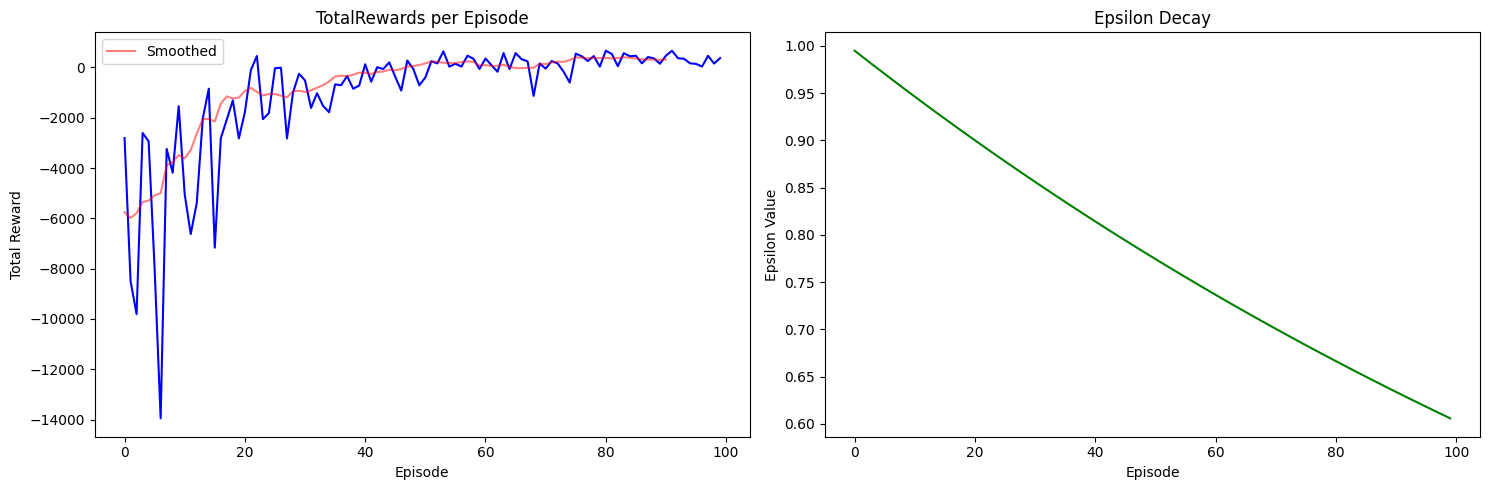

Full Q-table:
[[ -16.41  100.62   80.38   93.18   73.87]
 [  82.91   93.76   82.85  109.56   87.15]
 [  74.66   51.66   81.72  115.01   76.38]
 [  76.4     8.11   35.35   42.75   21.58]
 [  31.6    -0.38    3.24    7.4     8.01]
 [   0.8   -27.14   -0.38   -0.17   -0.2 ]
 [ -16.61  109.71   67.02   46.18   33.88]
 [  90.33  125.33   91.1    92.41   96.22]
 [  98.32   68.85   93.34    7.01  138.99]
 [ 105.85   11.11   29.42  -30.63   47.89]
 [  34.73   -0.47    5.31   -0.5     4.58]
 [   1.81  -18.92   -0.65   -0.27   -0.39]
 [ -58.84   82.51   44.93    4.55   25.39]
 [  48.61  -14.95  106.37   34.84   70.45]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -10.     -0.35   -0.2    -0.1    -0.37]
 [  -0.2   -10.      0.06   -0.19   -0.1 ]
 [ -64.37   23.89    4.99    0.78    4.25]
 [   1.98  -67.51   71.49    0.01   21.  ]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [   0.     -0.19   -0.1     0.89    0. 

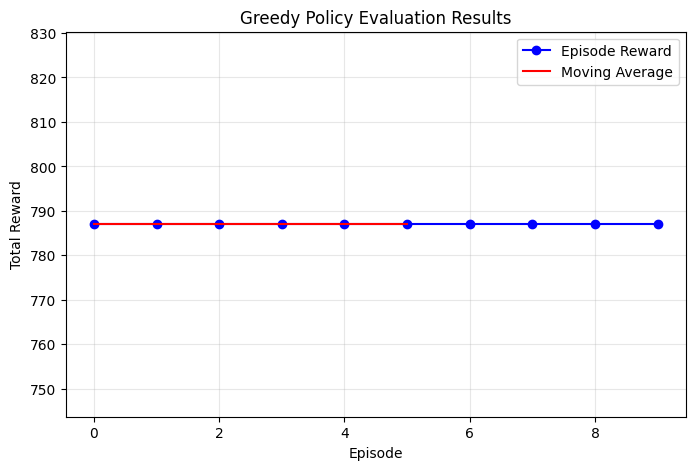


Training with epsilon decay = 0.999
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0.

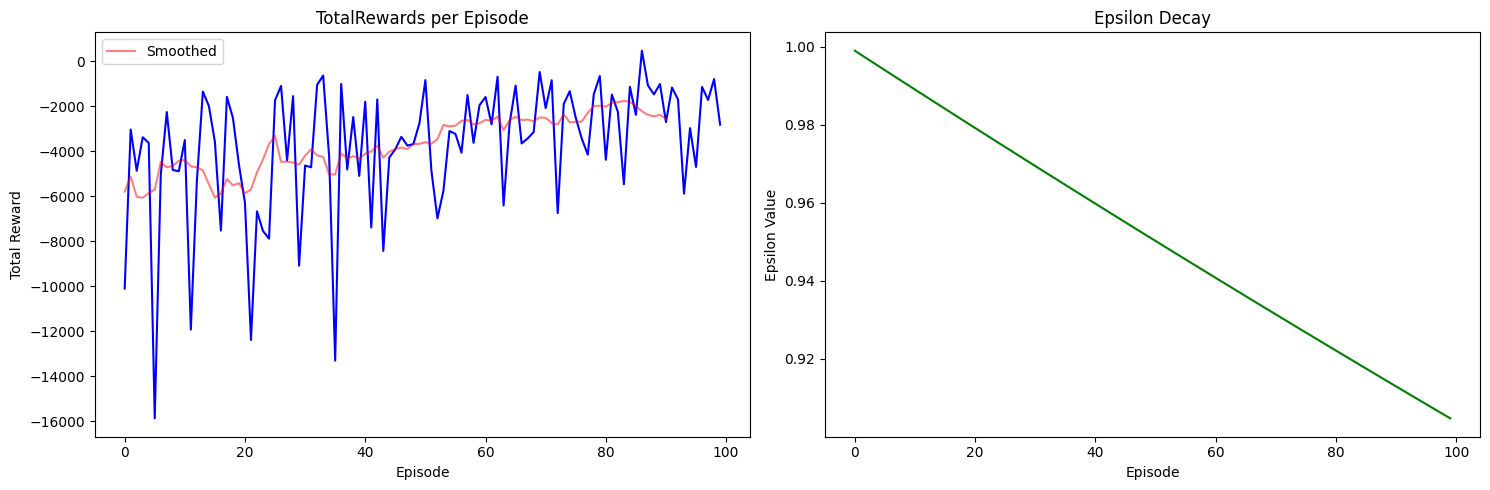

Full Q-table:
[[  -8.38   94.16   90.11   96.54   88.23]
 [  83.82   96.58   91.57  100.73   91.44]
 [  87.91   84.29   97.03  111.69   94.92]
 [  94.91   59.13   77.87   95.93   75.3 ]
 [  81.89   34.5    50.46   53.42   53.55]
 [  54.37  -76.06   29.01   32.91   25.81]
 [  -3.77  102.9    90.52   88.61   96.06]
 [  94.24  111.16   89.11   89.65   99.81]
 [  95.91   94.49   99.18    4.53  118.96]
 [ 105.32   81.39   86.54   -8.39   89.92]
 [  94.18   39.48   47.66   41.27   69.34]
 [  58.91  -67.42   23.85   16.41   27.43]
 [ -16.07   88.32   94.92   59.51   86.1 ]
 [  81.29   -7.27   99.06   80.49   88.6 ]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -56.25   17.61   66.87   44.74   41.58]
 [  40.34  -71.32   18.52   20.97   19.86]
 [ -47.56   69.09   77.56   43.41   40.4 ]
 [  52.99  -29.77   89.55   38.82   75.78]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -51.33   19.64   36.14   59.81   39.7

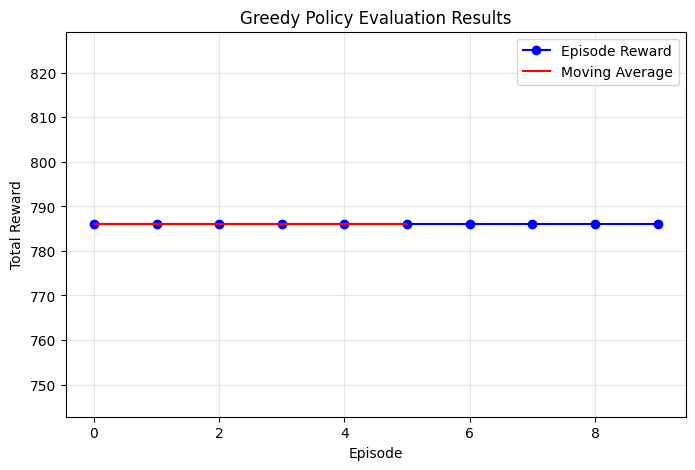

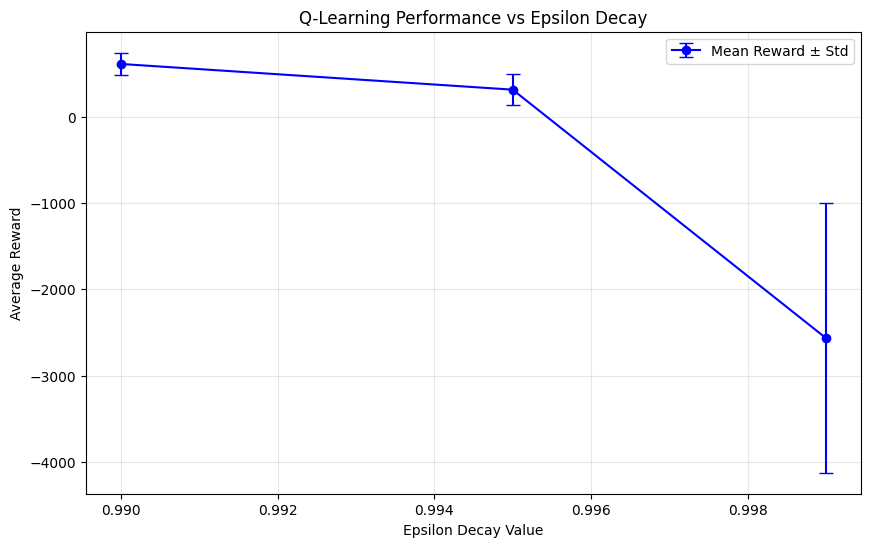


Results Summary:

Epsilon Decay = 0.99
Mean Reward: 613.90
Std Reward: 130.59

Epsilon Decay = 0.995
Mean Reward: 316.10
Std Reward: 181.41

Epsilon Decay = 0.999
Mean Reward: -2563.90
Std Reward: 1562.55

Best epsilon decay value: 0.99


In [15]:
#codeCell 15
env= DeterministicDroneDeliveryEnv()
results = epsilon_decay_tuning(env)

In [16]:
#codeCell 16
def sarsa(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, 
          min_epsilon=0.01, num_episodes=10, showplts=False, return_rewards=False):
   
    # Initialize Q-table
    q_table = np.zeros((n_states, n_actions), dtype=np.float32)
    print("Initial Q-table:")
    print(q_table)
    total_rewards = np.zeros(num_episodes, dtype=np.float32)
    epsilon_values = np.zeros(num_episodes, dtype=np.float32)
    
    try:
        for episode in range(num_episodes):
            state, _ = env.reset()
            state_idx = state_to_index(state)
            total_reward = 0
            done = False
            
            # Select first action using epsilon-greedy
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = int(np.argmax(q_table[state_idx]))
            
            while not done:
                # Take action
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state_idx = state_to_index(next_state)
                
                # Select next action using epsilon-greedy (SARSA is on-policy)
                if np.random.random() < epsilon:
                    next_action = env.action_space.sample()
                else:
                    next_action = int(np.argmax(q_table[next_state_idx]))
                
                # SARSA update
                current_q = q_table[state_idx, action]
                next_q = q_table[next_state_idx, next_action]
                q_table[state_idx, action] = current_q + alpha * (
                    reward + gamma * next_q - current_q
                )
                
                # Update state and action
                state_idx = next_state_idx
                action = next_action
                total_reward += reward
            
            # Update tracking variables
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            total_rewards[episode] = total_reward
            epsilon_values[episode] = epsilon
            
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(total_rewards[max(0, episode-9):episode+1])
                print(f"Episode {episode+1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}")
        
        if showplts:
            plot_training_results(total_rewards, epsilon_values, num_episodes)
        print("Full Q-table:")
        print(q_table)
        if return_rewards:
            return q_table, total_rewards
        return q_table
    
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return None

Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 

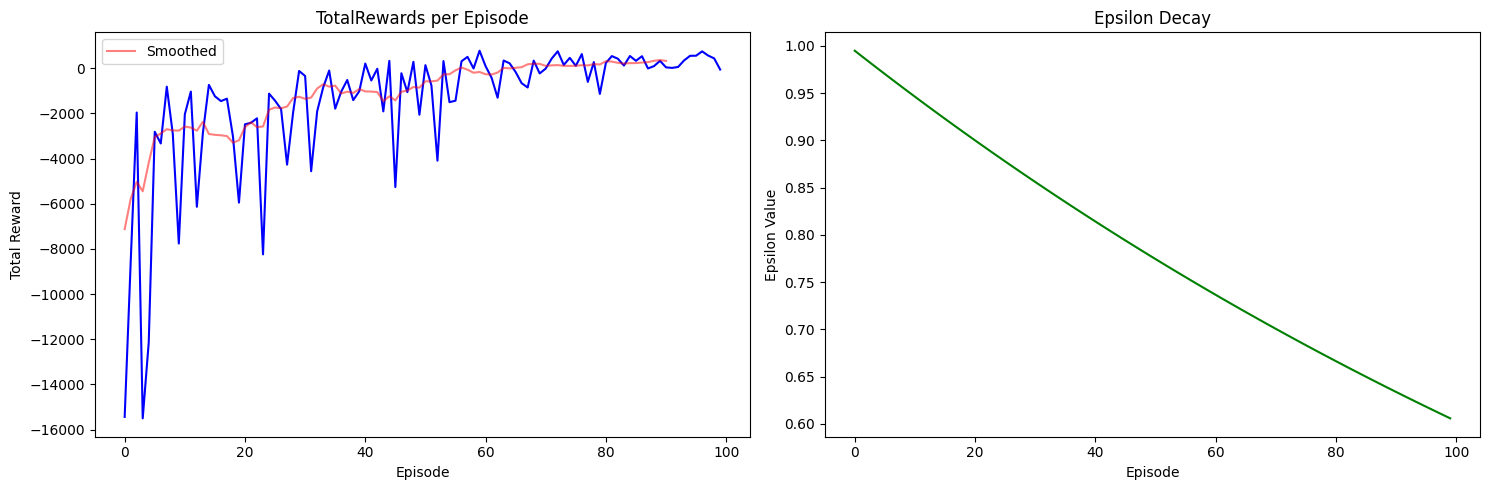

Full Q-table:
[[-151.89   -7.03  -38.38  -26.69  -30.6 ]
 [ -45.04    0.63   -9.46   -5.24   -8.87]
 [ -11.22   -5.34   -1.47   -0.     -2.06]
 [  -3.06   -4.35   -3.85  -21.55   -3.82]
 [  -3.74  -29.87   -2.7    -3.4    -3.15]
 [  -4.18 -111.05  -13.43   -5.4    -6.41]
 [-107.91   -3.26  -22.49  -14.75  -13.58]
 [ -22.76   12.22  -10.32  -14.52   -6.43]
 [  -2.04   -5.53   -1.71  -83.16   44.34]
 [   6.48   -3.64   -2.67  -91.51  -11.32]
 [  -8.64  -13.79   -1.99   -0.89   -3.36]
 [  -1.64  -65.15   -4.2    -2.52   -1.55]
 [-100.09  -13.97  -17.98   -7.92  -19.99]
 [ -10.96 -101.32   -7.05   -9.89   -9.65]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -41.09   -1.7    -2.06   -0.15   -1.9 ]
 [  -5.64  -41.04   -1.31   -1.17   -3.82]
 [ -60.54   -5.32  -26.9    -8.08   -7.5 ]
 [  -8.94  -57.5    -9.28   -2.17   -2.88]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [  -9.99   -0.67   -1.5    14.37   -0.0

In [17]:
# codeCell 17
env = DeterministicDroneDeliveryEnv()
q_table = sarsa(env, num_episodes=100, showplts=True)
with open('deterministic_env_sarsa_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 

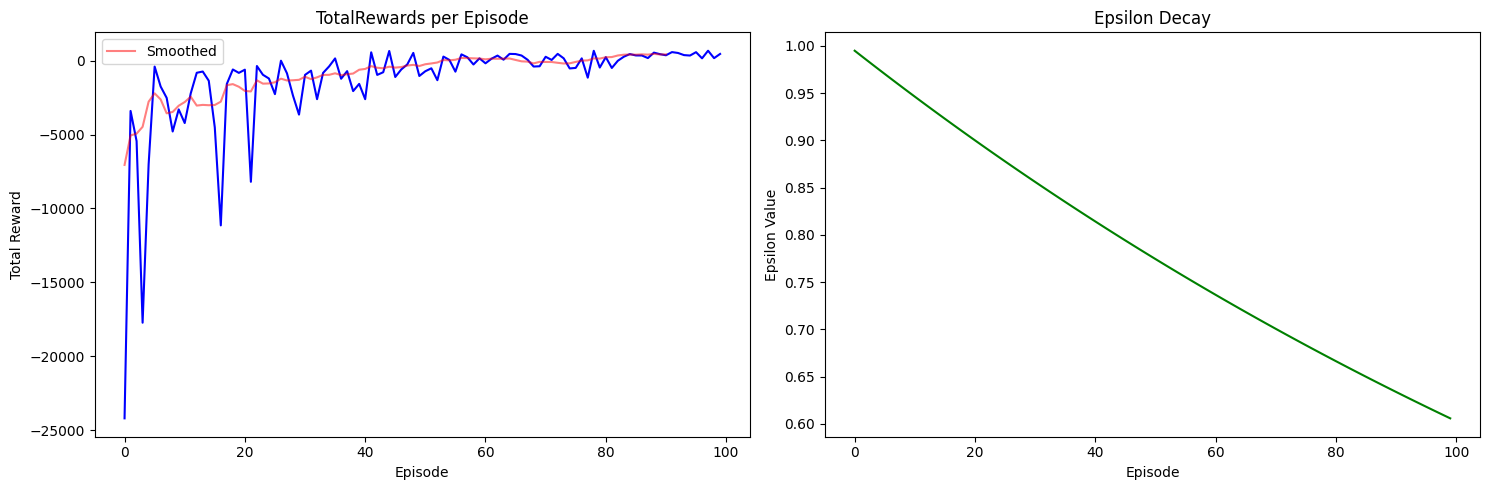

Full Q-table:
[[-17.04  87.06  71.48  78.51  68.2 ]
 [ 66.45  82.79  81.01  92.12  79.79]
 [ 76.11  41.57  65.19  93.26  72.71]
 [ 75.64   3.41  22.15  39.68  18.99]
 [ 14.75  -1.08  -0.14   3.79   0.06]
 [ -0.74 -58.88  -0.89  -0.18  -0.77]
 [-37.42  88.75  67.96  45.3   65.04]
 [ 74.69  95.89  81.65  73.75  88.26]
 [ 83.94  71.93  74.28  -1.15 100.39]
 [ 85.45  19.08  39.88 -25.01  43.95]
 [ 46.32  -0.89   2.92   0.81   9.95]
 [  9.67 -86.32  -1.05  -1.14  -0.92]
 [-45.84  30.78  66.59   0.92  16.31]
 [ 24.52 -42.03  83.52  10.6   34.62]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-61.36  -0.31   7.35  -9.75  -0.43]
 [ -0.96 -67.69  -0.25  -0.91  -0.97]
 [-54.07   0.22   7.31   3.05  -0.39]
 [  0.27 -40.72  44.23   0.57   6.41]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-68.    -0.81 -20.55  10.64  -0.43]
 [ -0.5  -45.84  -1.08   0.78  -0.81]
 [-46.22  -0.21   0.04  29.34   4.96]
 [  0.41   1.84  -0.43   4.29  -0.29

In [18]:
#codeCell 18
env=StochasticDroneDeliveryEnv()
q_table=q_learning(env,num_episodes=100,showplts=True)

# Save the Q-table/Policy table as a pickle file of the trained model
with open('stochastic_env_q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)


Training with gamma = 0.9
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [

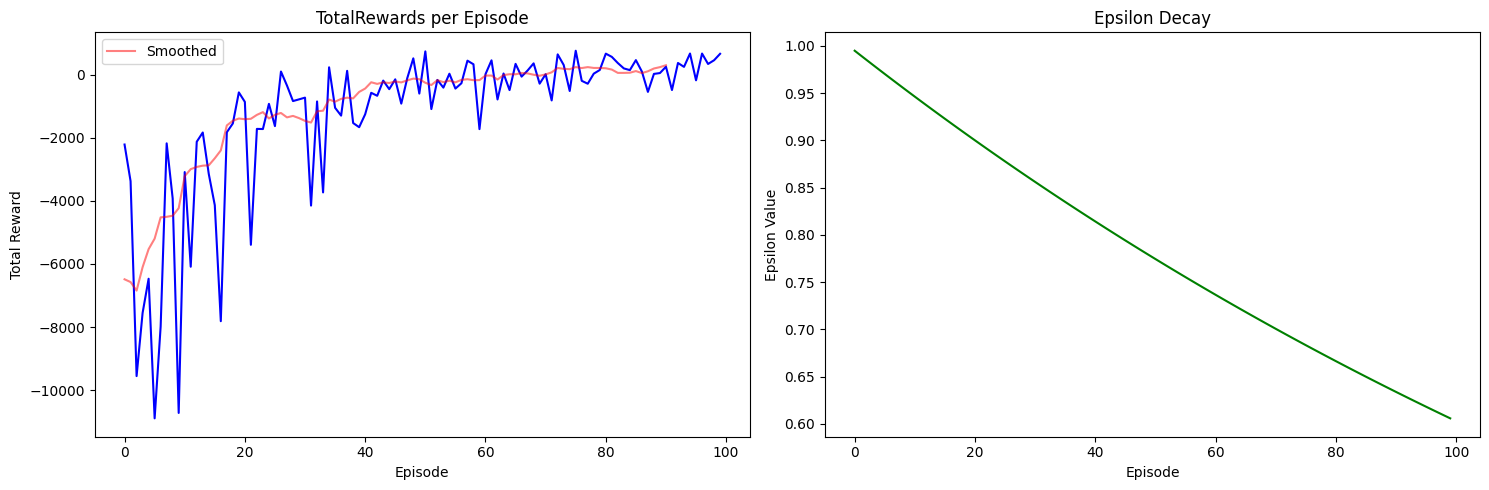

Full Q-table:
[[-36.66  64.58  45.48  48.54  45.17]
 [ 44.41  64.94  52.49  74.91  51.19]
 [ 38.14  32.98  55.94  84.64  54.05]
 [ 39.06   8.28  16.85  44.25  18.2 ]
 [ 24.69  -0.13   0.36  11.22   4.03]
 [  4.74 -71.61   0.17  -0.34  -0.79]
 [-30.35  72.02  35.09  23.56  46.49]
 [ 51.07  85.23  54.51  46.51  68.94]
 [ 61.77  43.12  62.28  -2.98 100.23]
 [ 50.3   17.47  30.28 -52.77  42.64]
 [ 33.61  -0.16   1.92   5.02  10.86]
 [  2.76 -31.1   -0.22  -0.52  -0.39]
 [-67.41  11.88  46.46   2.98  20.95]
 [ 22.44 -43.9   63.16   6.94  17.72]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-67.76  -0.49   3.69   1.53  -0.29]
 [ -0.44 -46.9   -0.31  -0.43  -0.2 ]
 [-80.24   3.82  13.9    1.56  -0.38]
 [ -0.2  -47.11  28.58  -2.52   2.73]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-46.33  -0.36  -0.26  10.39   0.88]
 [ -0.07 -34.41  -0.3    0.41  -0.61]
 [-28.76  -0.27  -0.36  17.15   2.7 ]
 [  0.66  -0.53  -0.1    4.01  -0.28

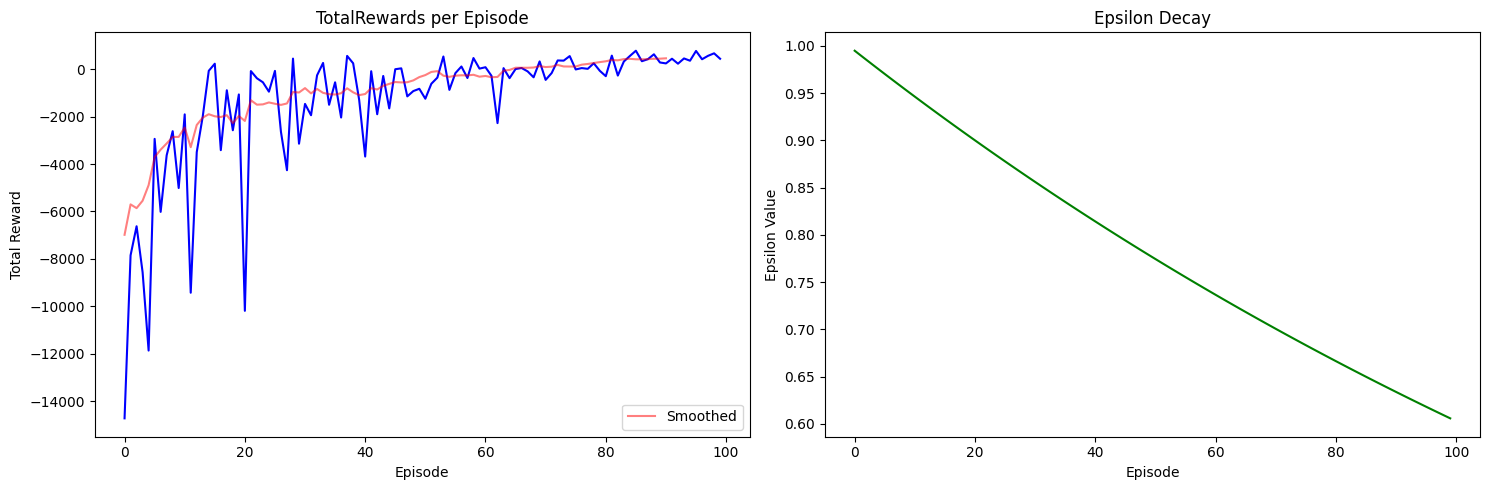

Full Q-table:
[[-32.01  63.39  58.53  81.22  65.28]
 [ 49.87  46.05  55.42  86.97  40.85]
 [ 43.1   11.47  21.7   78.89  10.51]
 [ 25.61   0.21   4.04  44.07   9.37]
 [  5.72  -0.94  -0.71  -0.56  -0.97]
 [ -0.89 -45.8   -0.82  -0.73  -0.59]
 [-27.91  91.16  63.37  62.95  75.47]
 [ 72.98 105.49  68.35  70.26  85.41]
 [ 62.86  40.42  57.56   0.83 123.16]
 [ 81.7    8.43  15.74 -59.6   37.96]
 [ 24.66  -0.91  -0.17  -0.62   7.86]
 [  4.23 -86.46  -0.76  -0.65  -0.75]
 [-45.74  43.94  76.22  18.8   42.07]
 [ 45.74 -45.89  82.47  24.07  47.95]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-27.08  -0.74  -4.89   1.46  -0.32]
 [ -0.49 -57.06  -0.48  -0.45  -0.49]
 [-77.33  17.33  35.55   4.13   3.09]
 [  8.51 -39.44  52.19   0.57  12.89]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-41.3    1.14  -0.19   0.91  -0.14]
 [  0.35 -19.01  -0.36   2.69  -0.41]
 [-55.42  -0.34  -0.07  21.08   0.84]
 [  0.64  -0.71   8.62   1.66   0.09

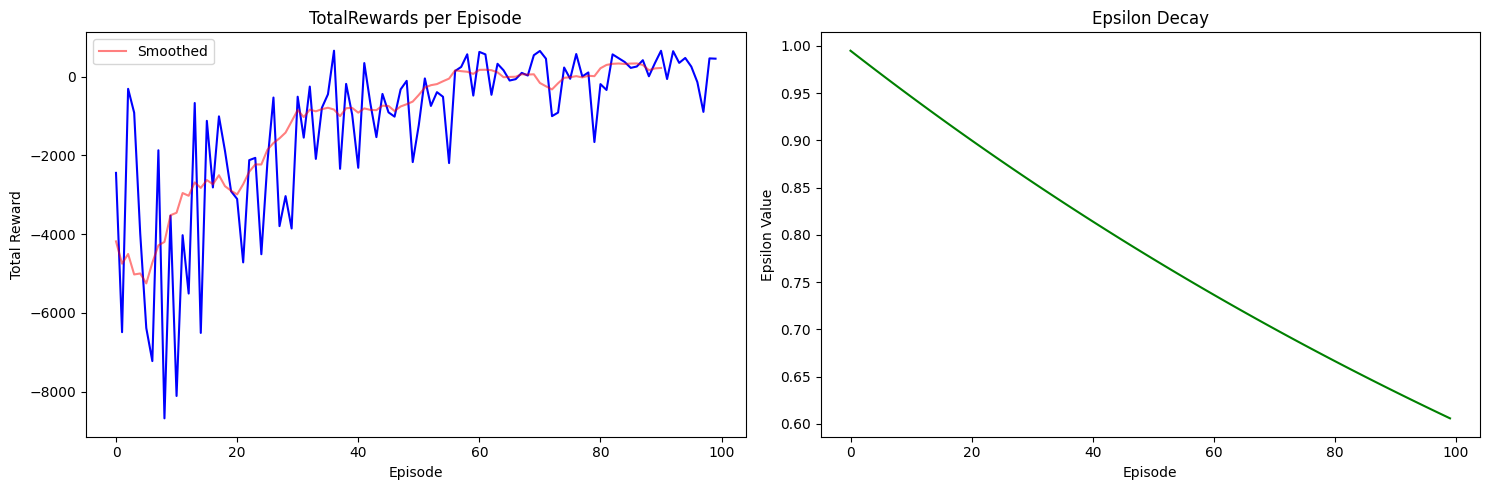

Full Q-table:
[[ -9.9   92.58  75.97  83.29  79.92]
 [ 71.56  89.69  79.65  99.53  78.62]
 [ 68.33  54.97  75.08 102.45  75.13]
 [ 81.84  17.68  32.56  32.34  31.79]
 [ 38.56   0.1   15.51   6.14  13.9 ]
 [  2.64 -52.22  -0.71   2.42  -0.71]
 [-17.95  98.12  48.06  43.04  53.11]
 [ 72.79 107.08  88.69  58.17  90.4 ]
 [ 79.53  58.56  76.84   7.67 116.79]
 [ 88.3   13.03  51.68 -39.78  28.37]
 [ 39.81   3.61   6.14   0.03  12.03]
 [ 15.13 -73.65  -0.52  -0.57   2.12]
 [-53.44  29.02  70.91  14.53  28.57]
 [ 30.69 -44.44  76.59  13.7   45.17]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-60.71  -0.48   6.61   0.05  -0.5 ]
 [  0.32 -34.48  -0.43  -0.58  -0.3 ]
 [-55.42   7.53  14.82  28.85   3.25]
 [  2.49 -50.51  32.37  -4.49   2.41]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-13.8   -0.28  -7.54   8.11   0.38]
 [ -0.21 -17.2   -0.29   0.82  -0.3 ]
 [-54.15   0.64   8.26  50.14  19.37]
 [  7.36   0.39   1.05   6.14   0.43

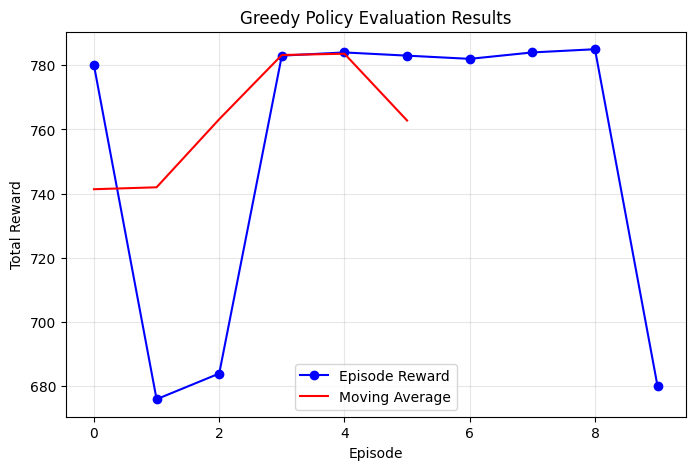

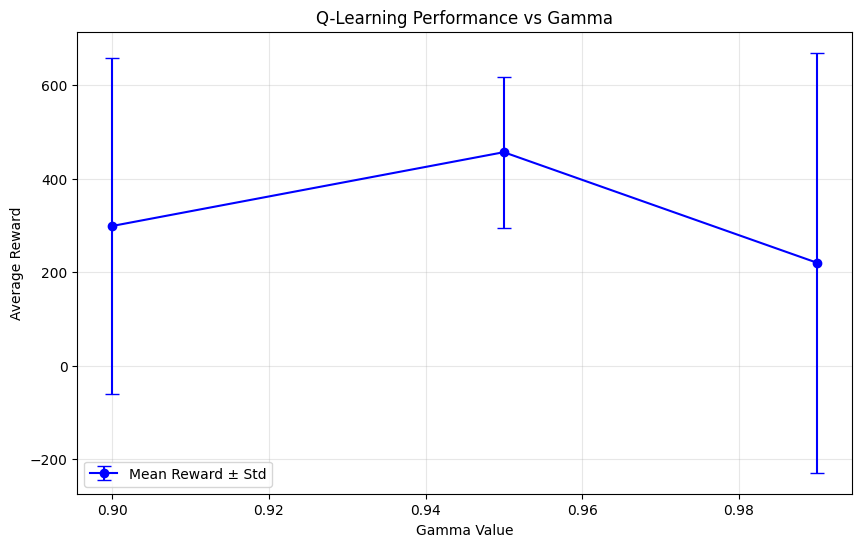


Results Summary:

Gamma = 0.9
Mean Reward: 298.90
Std Reward: 358.94

Gamma = 0.95
Mean Reward: 456.80
Std Reward: 161.77

Gamma = 0.99
Mean Reward: 220.20
Std Reward: 449.49

Best gamma value: 0.95


In [19]:
#codeCell 20
env= StochasticDroneDeliveryEnv()
results = gamma_tuning(env)


Training with epsilon decay = 0.99
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 

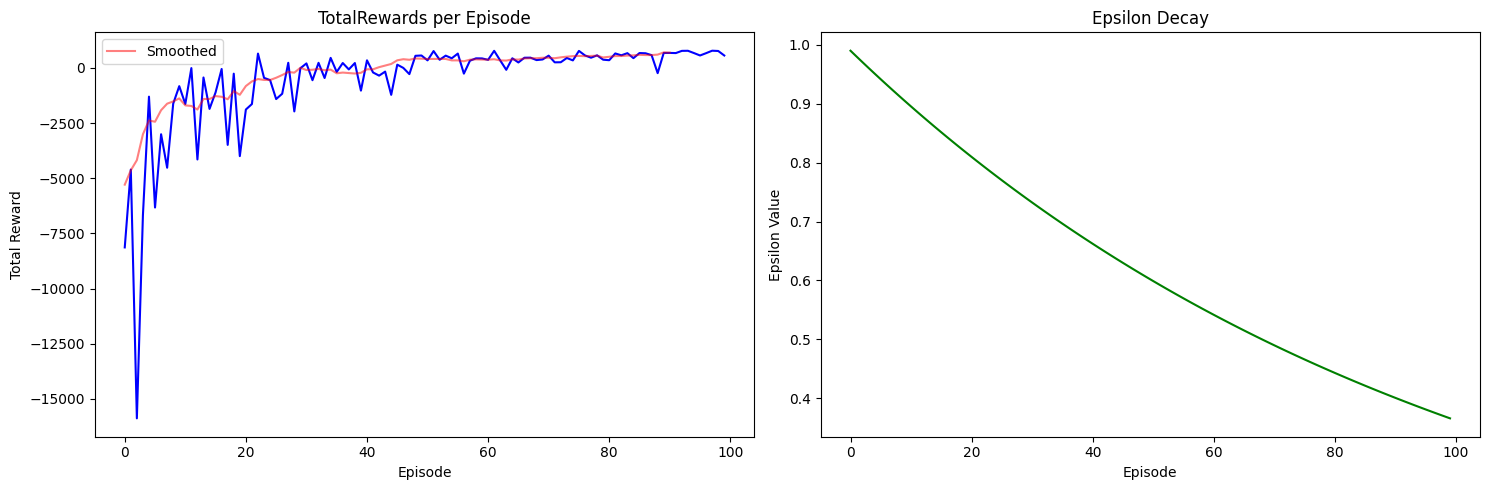

Full Q-table:
[[-27.58  87.69  55.61  52.78  58.64]
 [ 54.5   62.82  57.07  95.8   51.42]
 [ 21.91  19.86  46.94  92.72  45.63]
 [ 48.74  -0.71   1.77   1.87  10.17]
 [ -0.1   -0.5   -0.49  -0.28  -0.36]
 [ -0.3  -10.    -0.19  -0.34  -0.2 ]
 [-44.9   81.52  24.16  20.06  35.58]
 [ 48.36 106.12  76.99  51.41  80.09]
 [ 78.71  41.15  58.85   2.32 116.1 ]
 [ 76.02   1.52   2.3  -34.4   16.45]
 [ 16.22  -0.11  -0.29   0.     0.19]
 [ -0.19 -10.    -0.1   -0.27  -0.19]
 [-57.02  42.75  13.37   0.23   7.46]
 [  8.9  -55.36  76.83  -4.04  19.58]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [ -8.29  -0.19   1.85  -0.19  -0.1 ]
 [ -0.25 -19.    -0.11  -0.1    0.  ]
 [-35.59  -0.23  -0.22   1.36  -0.43]
 [ -0.28 -33.75   7.58  -0.22  -0.29]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-40.95  -0.1   -0.19  -0.19  -0.1 ]
 [ -0.1  -10.    -0.1   -0.1    0.  ]
 [ -9.1   -0.44  -0.12  13.69  -0.02]
 [  0.49   0.16   0.26   0.97  -0.1 

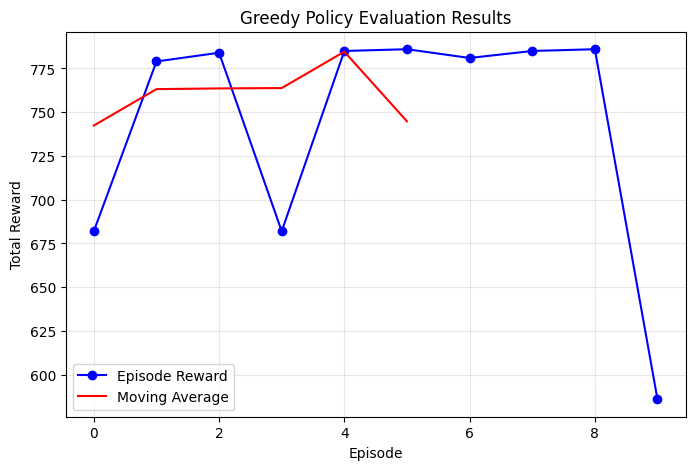


Training with epsilon decay = 0.995
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0.

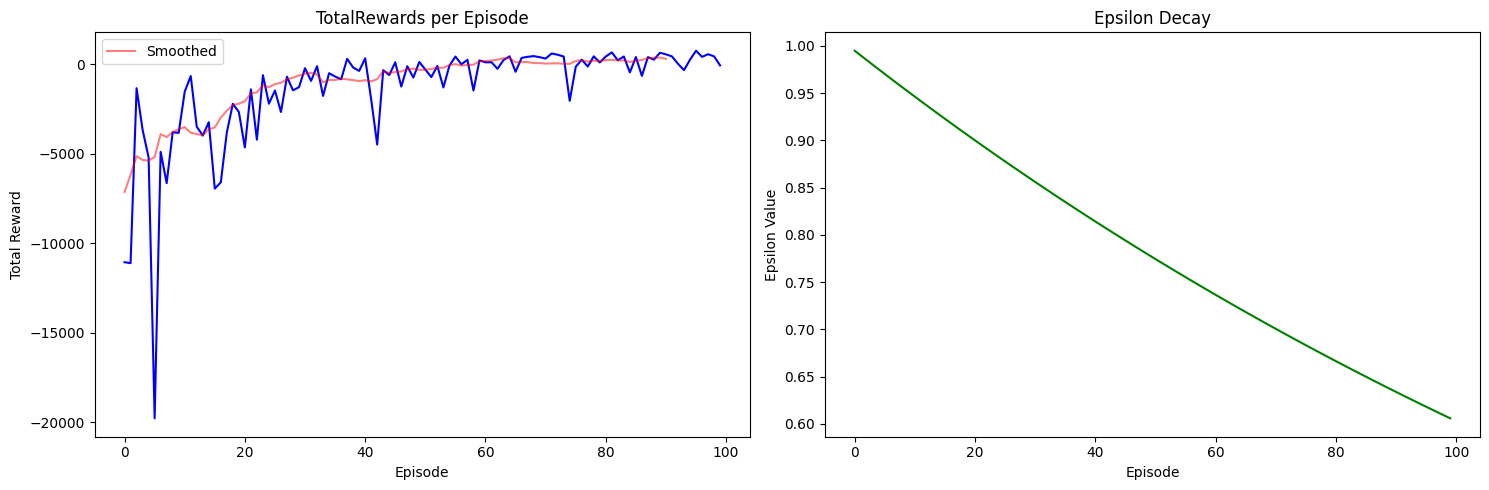

Full Q-table:
[[-26.95  99.82  71.41  74.05  81.88]
 [ 81.12  93.95  86.23 110.71  83.5 ]
 [ 75.45  59.57  67.73 124.6   78.61]
 [ 59.36  29.36  30.7   75.17  32.77]
 [ 42.45   7.35  18.16  18.74  16.96]
 [ 14.   -53.08   2.03   1.18   5.01]
 [-28.12  93.6   54.65  39.29  61.37]
 [ 77.34 126.48  94.07  50.17  97.73]
 [ 92.39  80.2   90.16  21.74 155.59]
 [112.43  26.    48.74 -22.32  56.97]
 [ 63.02   3.35  15.83   4.86  26.58]
 [  9.83 -42.32   1.46  -0.68   0.44]
 [-52.7   33.28  64.75   2.15  15.36]
 [ 20.13 -49.62  67.8    4.4   24.92]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-50.25  -0.77   3.09  -7.97  -0.22]
 [ -0.65 -57.13  -0.34  -0.66  -0.92]
 [-74.29   6.56   2.     9.53   1.89]
 [  4.4  -50.12  18.93   0.25   5.22]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-65.88   1.05  -0.02  -8.28  -0.72]
 [ -0.43 -24.81  -0.63   1.74  -0.64]
 [-61.99  -0.5    1.95  28.38   7.85]
 [  4.61  -0.19   1.54   1.74  -0.07

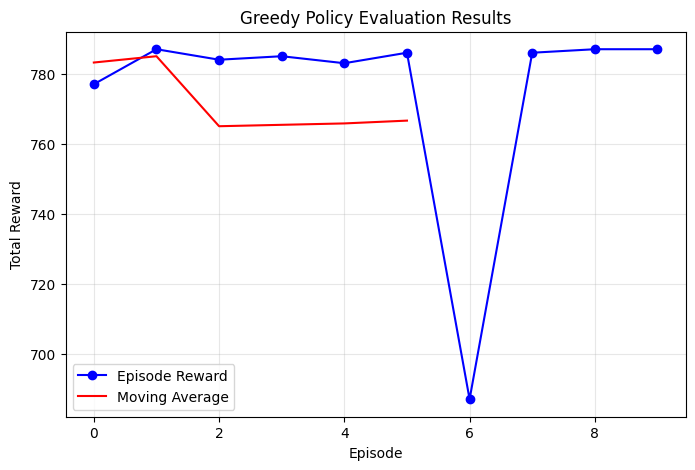


Training with epsilon decay = 0.999
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0.

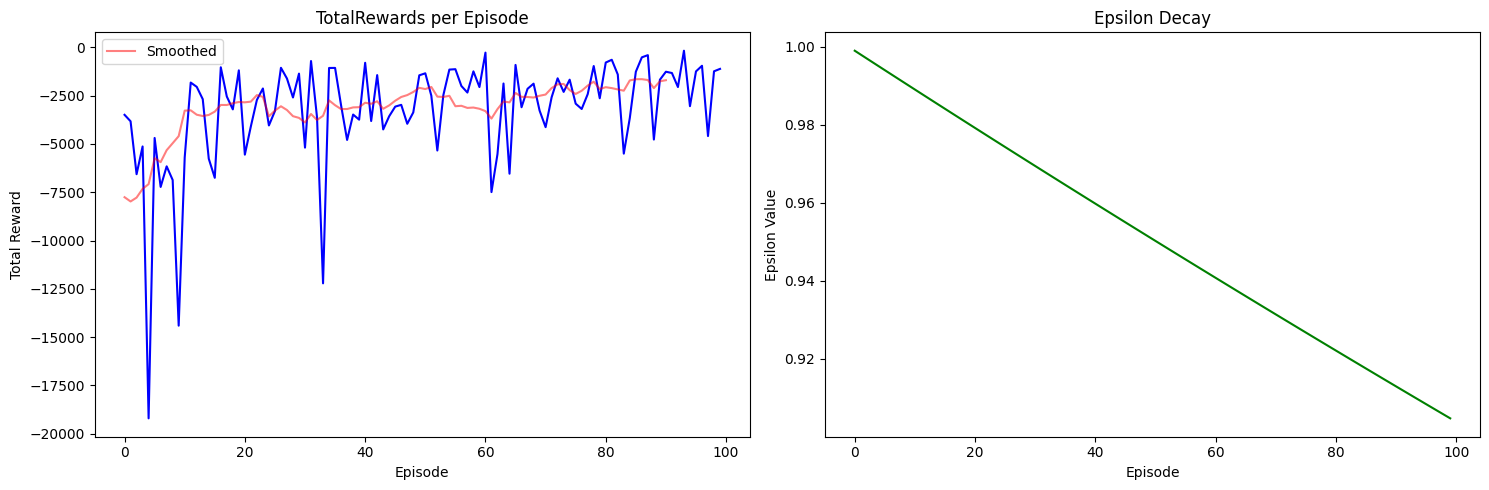

Full Q-table:
[[-10.35  88.67  83.53  83.58  84.44]
 [ 83.98  93.07  86.3   90.42  88.15]
 [ 86.27  79.71  88.84 100.29  91.87]
 [ 89.5   60.44  75.98  79.38  80.2 ]
 [ 78.34  38.55  60.55  47.27  53.51]
 [ 55.19 -58.78  30.68  28.19  30.73]
 [-11.68  89.73  80.94  75.64  78.05]
 [ 80.09  99.73  86.62  80.06  91.62]
 [ 79.43  76.49  86.    10.22 110.73]
 [ 92.01  58.65  73.14 -16.99  77.59]
 [ 65.35  35.91  57.24  25.8   50.02]
 [ 49.61 -63.85  32.09  10.36  32.46]
 [-17.06  76.36  79.61  42.21  69.32]
 [ 65.54 -17.74  88.84  45.74  73.15]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-57.52  11.61  36.17  34.99  12.67]
 [ 14.07 -57.26  20.69   6.53   4.74]
 [-54.74  40.04  56.25  44.98  35.39]
 [ 40.15 -57.7   59.23  14.63  26.8 ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [-43.97  17.31   5.68  59.78  27.65]
 [ 16.06 -60.23   2.28  25.82   7.25]
 [-36.12  17.77  24.28  68.08  43.1 ]
 [ 36.25   0.77  20.27  28.1   12.  

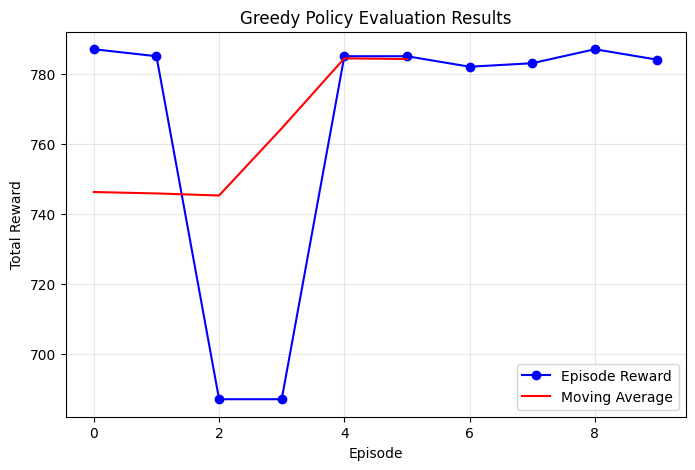

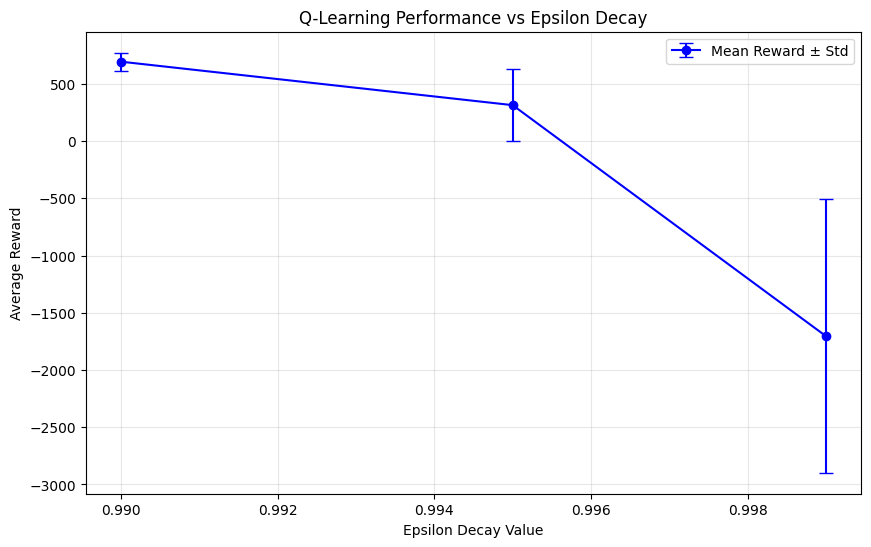


Results Summary:

Epsilon Decay = 0.99
Mean Reward: 694.00
Std Reward: 78.57

Epsilon Decay = 0.995
Mean Reward: 314.50
Std Reward: 316.72

Epsilon Decay = 0.999
Mean Reward: -1703.10
Std Reward: 1194.23

Best epsilon decay value: 0.99


In [20]:
#codeCell 21
env= StochasticDroneDeliveryEnv()
results = epsilon_decay_tuning(env)  

Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 

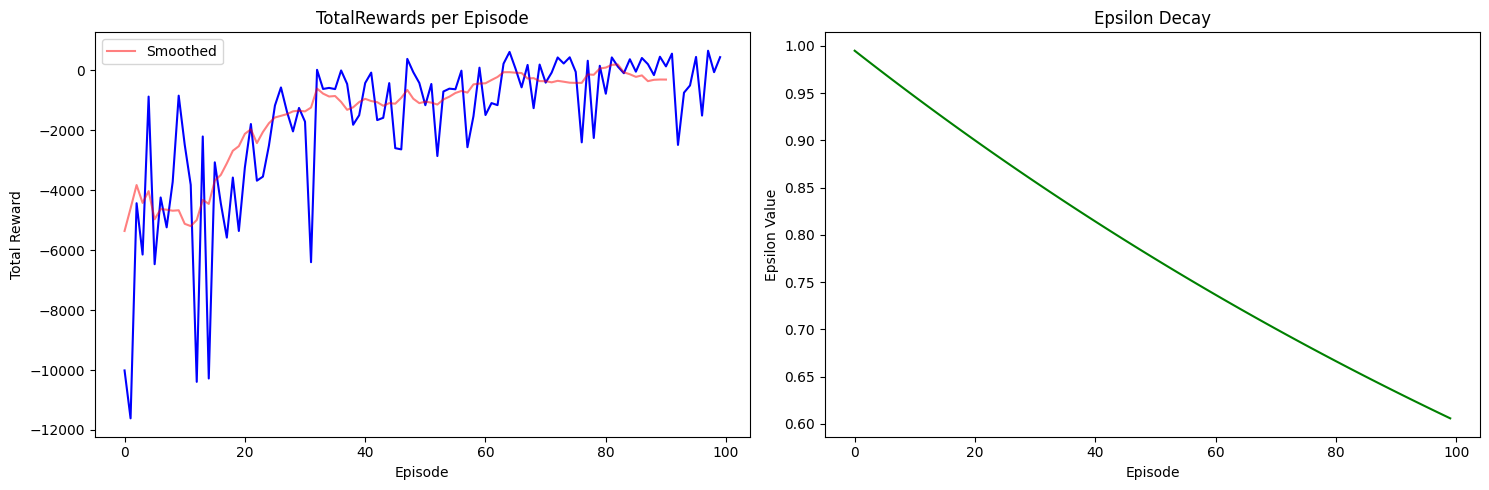

Full Q-table:
[[-130.3   -10.26  -36.8   -34.97  -33.72]
 [ -31.54    1.81  -14.44  -17.51   -9.69]
 [  -7.31   -4.66    4.01   13.02   -1.54]
 [   1.25   -5.31   -3.67  -24.26   -6.2 ]
 [  -2.98  -24.93   -3.66   -5.62   -5.83]
 [  -4.15 -101.8    -6.81   -6.08   -4.42]
 [-109.73  -13.41  -35.27  -28.23  -45.67]
 [ -39.01    5.63   -8.61  -12.94  -10.84]
 [ -19.55  -25.31   -2.81  -70.12   53.59]
 [   1.45   -3.22   -4.57  -86.85  -20.87]
 [ -31.58   -6.32   -2.2    -3.53   -3.5 ]
 [  -3.56  -71.21  -13.43  -18.54   -8.42]
 [-122.82  -21.43  -28.21  -23.64  -24.11]
 [ -21.36  -82.55   -7.56  -20.22  -17.17]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -83.7   -13.43   -9.09  -15.29   -5.99]
 [ -11.76  -78.73  -15.32  -14.24  -31.33]
 [ -72.51   -8.61  -18.1   -12.65  -14.44]
 [  -9.1   -65.84  -10.9    -4.28  -11.42]
 [   0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.  ]
 [ -68.67  -11.55  -24.14   -6.42  -12.5

In [21]:
#codeCell 22
env = StochasticDroneDeliveryEnv()
q_table = sarsa(env, num_episodes=100, showplts=True)
with open('stochastic_env_sarsa_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)


In [22]:
# Test both policies
def evaluate_policy(env, q_table, num_episodes=5, max_steps=100):
   total_rewards = []
   steps_to_complete = []
   success_rate = 0
   
   for episode in range(num_episodes):
      state, _ = env.reset()
      state_idx = state_to_index(state)
      episode_reward = 0
      done = False
      step = 0
      
      print(f"\nEpisode {episode+1}:")
      while not done and step < max_steps:
         # Choose action greedily
         action = int(np.argmax(q_table[state_idx]))
         next_state, reward, terminated, truncated, _ = env.step(action)
         done = terminated or truncated
         next_state_idx = state_to_index(next_state)
         
         # Track progress
         episode_reward += reward
         print(f"  Step {step+1}: Action={action}, Reward={reward}, State={next_state}")
         
         # Update for next iteration
         state_idx = next_state_idx
         step += 1
         
         if done:
            if terminated and reward > 0:  # Successfully completed
               success_rate += 1
            steps_to_complete.append(step)
      
      total_rewards.append(episode_reward)
      print(f"  Episode reward: {episode_reward}")
   
   success_percentage = (success_rate / num_episodes) * 100
   avg_reward = np.mean(total_rewards)
   avg_steps = np.mean(steps_to_complete) if steps_to_complete else "N/A"
   
   print(f"\nAverage reward: {avg_reward:.2f}")
   print(f"Success rate: {success_percentage:.1f}%")
   print(f"Average steps to complete: {avg_steps}")
   
   return {
      "avg_reward": avg_reward,
      "success_rate": success_percentage,
      "avg_steps": avg_steps,
      "rewards": total_rewards
   }

Training Q-Learning...
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0

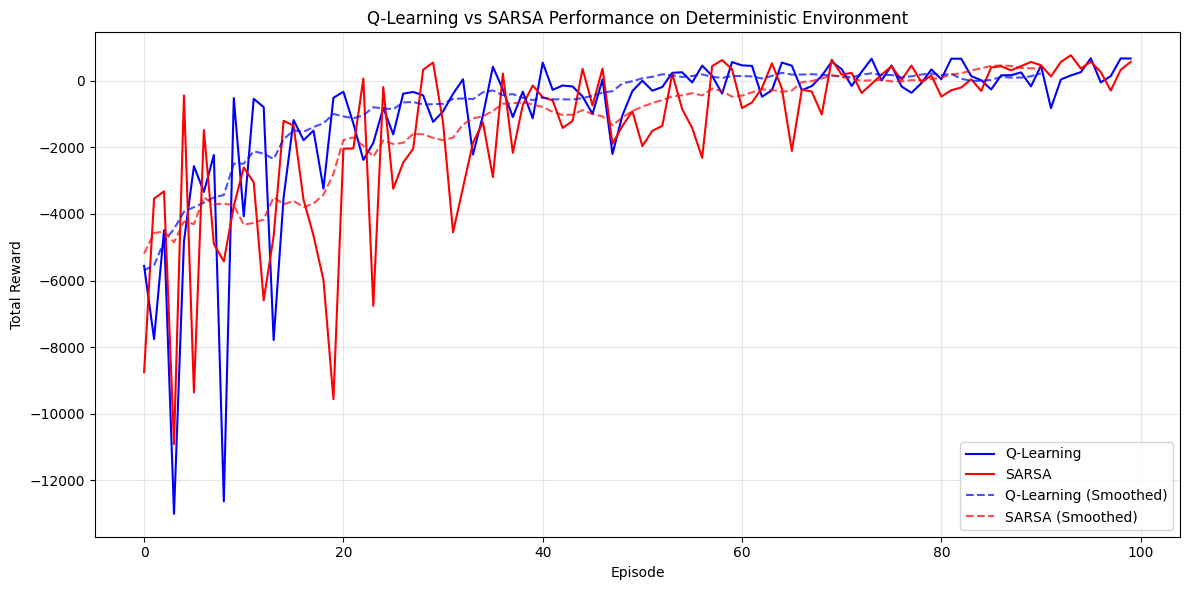


Final Results:
Q-Learning - Mean reward (last 10 episodes): 220.20
SARSA      - Mean reward (last 10 episodes): 373.90

Testing Q-Learning Policy:

Episode 1:
  Step 1: Action=3, Reward=-1, State=(array([1, 0]), 3, array([False, False, False]))
  Step 2: Action=1, Reward=-1, State=(array([1, 1]), 3, array([False, False, False]))
  Step 3: Action=1, Reward=-1, State=(array([1, 2]), 3, array([False, False, False]))
  Step 4: Action=4, Reward=100, State=(array([1, 2]), 2, array([ True, False, False]))
  Step 5: Action=1, Reward=-1, State=(array([1, 3]), 2, array([ True, False, False]))
  Step 6: Action=1, Reward=-1, State=(array([1, 4]), 2, array([ True, False, False]))
  Step 7: Action=3, Reward=-1, State=(array([2, 4]), 2, array([ True, False, False]))
  Step 8: Action=3, Reward=-1, State=(array([3, 4]), 2, array([ True, False, False]))
  Step 9: Action=3, Reward=-1, State=(array([4, 4]), 2, array([ True, False, False]))
  Step 10: Action=4, Reward=100, State=(array([4, 4]), 1, array([

In [23]:
# Compare Q-Learning vs SARSA on Deterministic Environment
env = DeterministicDroneDeliveryEnv()

# Training parameters
num_episodes = 100
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01

# Train Q-Learning
print("Training Q-Learning...")
q_learning_table, q_learning_rewards = q_learning(
    env=env,
    alpha=alpha,
    gamma=gamma, 
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=min_epsilon,
    num_episodes=num_episodes,
    showplts=False,
    return_rewards=True
)

# Train SARSA
print("\nTraining SARSA...")
sarsa_table, sarsa_rewards = sarsa(
    env=env,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=min_epsilon,
    num_episodes=num_episodes,
    showplts=False,
    return_rewards=True
)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot rewards
plt.plot(np.arange(num_episodes), q_learning_rewards, 'b-', label='Q-Learning')
plt.plot(np.arange(num_episodes), sarsa_rewards, 'r-', label='SARSA')

# Plot smoothed rewards
window_size = 10
smoothed_q_rewards = np.convolve(q_learning_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_sarsa_rewards = np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid')

plt.plot(np.arange(len(smoothed_q_rewards)), smoothed_q_rewards, 'b--', alpha=0.7, label='Q-Learning (Smoothed)')
plt.plot(np.arange(len(smoothed_sarsa_rewards)), smoothed_sarsa_rewards, 'r--', alpha=0.7, label='SARSA (Smoothed)')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning vs SARSA Performance on Deterministic Environment')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Results:")
print(f"Q-Learning - Mean reward (last 10 episodes): {np.mean(q_learning_rewards[-10:]):.2f}")
print(f"SARSA      - Mean reward (last 10 episodes): {np.mean(sarsa_rewards[-10:]):.2f}")


#  Test the policies
print("\nTesting Q-Learning Policy:")
q_learning_test_results = evaluate_policy(env, q_learning_table, num_episodes=5)
print("\nTesting SARSA Policy:")
sarsa_test_results = evaluate_policy(env, sarsa_table, num_episodes=5)

print("\nInterpretation of Results:")
print("""
In this deterministic environment:

1. Learning Dynamics: The graph shows how Q-Learning and SARSA learn over time. 
   Both algorithms eventually learn effective policies, but their learning trajectories differ.

2. Off-policy vs On-policy: Q-Learning, being off-policy, learns the optimal policy regardless
   of the exploration policy being used. SARSA, being on-policy, learns a policy that considers
   the exploration strategy.

3. Performance: In a fully deterministic environment, Q-Learning tends to converge to the optimal
   policy faster as it directly learns from the best next action. SARSA is more conservative as
   it considers the actual (potentially exploratory) next action.

4. Stability: SARSA typically shows more stable learning curves because it accounts for the 
   exploration strategy in its updates, rather than assuming optimal future choices.

5. Final Policy: Both algorithms should eventually converge to similar policies in a deterministic
   environment with sufficient training.
""")

Training Q-Learning...
Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0

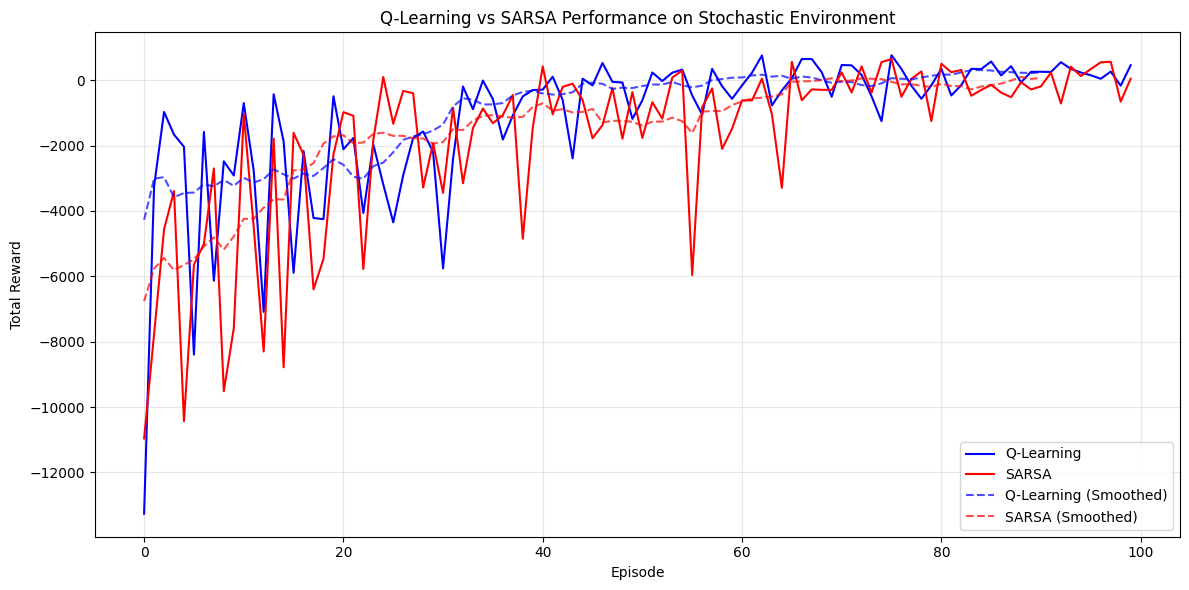


Final Results:
Q-Learning - Mean reward (last 10 episodes): 238.00
SARSA      - Mean reward (last 10 episodes): 70.60

Testing Q-Learning Policy:

Episode 1:
  Step 1: Action=3, Reward=-1, State=(array([1, 0]), 3, array([False, False, False]))
  Step 2: Action=1, Reward=-1, State=(array([1, 1]), 3, array([False, False, False]))
  Step 3: Action=1, Reward=-1, State=(array([1, 2]), 3, array([False, False, False]))
  Step 4: Action=4, Reward=100, State=(array([1, 2]), 2, array([ True, False, False]))
  Step 5: Action=2, Reward=-1, State=(array([0, 2]), 2, array([ True, False, False]))
  Step 6: Action=1, Reward=-1, State=(array([0, 3]), 2, array([ True, False, False]))
  Step 7: Action=1, Reward=-1, State=(array([0, 4]), 2, array([ True, False, False]))
  Step 8: Action=3, Reward=-1, State=(array([1, 4]), 2, array([ True, False, False]))
  Step 9: Action=3, Reward=-1, State=(array([2, 4]), 2, array([ True, False, False]))
  Step 10: Action=3, Reward=-1, State=(array([3, 4]), 2, array([ T

In [24]:
# Compare Q-Learning vs SARSA on Stochastic Environment
env = StochasticDroneDeliveryEnv()

# Training parameters
num_episodes = 100
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01

# Train Q-Learning
print("Training Q-Learning...")
q_learning_table, q_learning_rewards = q_learning(
    env=env,
    alpha=alpha,
    gamma=gamma, 
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=min_epsilon,
    num_episodes=num_episodes,
    showplts=False,
    return_rewards=True
)

# Train SARSA
print("\nTraining SARSA...")
sarsa_table, sarsa_rewards = sarsa(
    env=env,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=min_epsilon,
    num_episodes=num_episodes,
    showplts=False,
    return_rewards=True
)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot rewards
plt.plot(np.arange(num_episodes), q_learning_rewards, 'b-', label='Q-Learning')
plt.plot(np.arange(num_episodes), sarsa_rewards, 'r-', label='SARSA')

# Plot smoothed rewards
window_size = 10
smoothed_q_rewards = np.convolve(q_learning_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_sarsa_rewards = np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid')

plt.plot(np.arange(len(smoothed_q_rewards)), smoothed_q_rewards, 'b--', alpha=0.7, label='Q-Learning (Smoothed)')
plt.plot(np.arange(len(smoothed_sarsa_rewards)), smoothed_sarsa_rewards, 'r--', alpha=0.7, label='SARSA (Smoothed)')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning vs SARSA Performance on Stochastic Environment')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Results:")
print(f"Q-Learning - Mean reward (last 10 episodes): {np.mean(q_learning_rewards[-10:]):.2f}")
print(f"SARSA      - Mean reward (last 10 episodes): {np.mean(sarsa_rewards[-10:]):.2f}")



print("\nTesting Q-Learning Policy:")
q_learning_test_results = evaluate_policy(env, q_learning_table, num_episodes=5)
print("\nTesting SARSA Policy:")
sarsa_test_results = evaluate_policy(env, sarsa_table, num_episodes=5)

print("\nInterpretation of Results:")
print("""
In this stochastic environment:

1. Learning Dynamics: The comparison between Q-Learning and SARSA reveals how each algorithm 
   adapts to uncertainty in action outcomes.

2. Off-policy vs On-policy: SARSA's on-policy nature provides a significant advantage in 
   stochastic environments, as it learns a policy that accounts for the randomness in action results.

3. Performance: Q-Learning might show more variability in performance since it always 
   optimistically assumes the best next action will be taken, which isn't always possible 
   in a stochastic environment.

4. Safety: SARSA tends to learn safer policies in stochastic environments, as it directly 
   incorporates the uncertainty of exploration into its value updates.

5. Long-term benefits: While Q-Learning might appear to learn faster initially, SARSA often 
   produces more reliable policies in stochastic domains where the optimistic assumptions 
   of Q-Learning can lead to risky behavior.
""")

In [25]:
# Explanation of Tabular Methods Used in This Project

# 1. Q-Learning
# Q-Learning is an off-policy temporal difference (TD) learning algorithm that approximates the optimal 
# action-value function Q*(s,a) regardless of the agent's policy.
# 
# Update function:
# Q(s,a) ← Q(s,a) + α * [r + γ * max_a' Q(s',a') - Q(s,a)]
# 
# Key features:
# - Off-policy: Learns the optimal policy while following an exploration policy
# - Uses maximum estimated value for the next state (max_a' Q(s',a'))
# - Tends to be more aggressive/optimistic in its value estimates
# - In our implementation, we used epsilon-greedy exploration with decay

# 2. SARSA
# SARSA is an on-policy TD learning algorithm that learns the value of the policy being followed.
# 
# Update function:
# Q(s,a) ← Q(s,a) + α * [r + γ * Q(s',a') - Q(s,a)]
# 
# Key features:
# - On-policy: Learns values for the policy it's actually following
# - Uses the actual next action's value for updates
# - Generally more conservative than Q-learning
# - Better suited for stochastic environments

# 3. Key Components of Both Implementations:
# - State encoding: Reduced state space by using position and delivery status only
# - Epsilon-greedy exploration strategy with decaying epsilon
# - Hyperparameter tuning for alpha (learning rate) and gamma (discount factor)

# Criteria for Good Reward Function:
# A good reward function should be:
# 1. Sparse but informative: In our environment, we used -1 for each step (encouraging efficiency),
#    -100 for no-fly zones (strongly discouraging dangerous actions), +100 for successful deliveries,
#    and +500 for completing all tasks (encouraging goal completion).
# 
# 2. Aligned with task objectives: The rewards directly correspond to the goal of delivering packages
#    efficiently while avoiding restricted areas.
#
# 3. Properly scaled: The relative magnitudes of rewards (-1 vs -100 vs +100 vs +500) reflect their
#    importance in the task hierarchy.
#
# 4. Consistent between environments: Both deterministic and stochastic environments use the same
#    reward structure, allowing for fair comparison of algorithms.
#
# The reward function we used successfully shaped the behavior of both algorithms to complete deliveries
# while avoiding no-fly zones. In the stochastic environment, we saw that SARSA tended to learn more
# robust policies due to its on-policy nature, better accounting for the uncertainty of actions.